In [1]:
%load_ext autoreload
%autoreload 2

# Import

In [2]:
import numpy as np
import hypertools as hyp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import itertools
from collections import defaultdict

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering, KMeans
from tommas.viz.embedding_plot import extract_embeddings_and_labels
from sklearn.metrics import silhouette_samples, silhouette_score

from transformers import GPT2Model, GPT2Config, GPT2LMHeadModel, GPT2Tokenizer, GPT2ForSequenceClassification, PreTrainedTokenizerFast
from tokenizers import Tokenizer, models, normalizers, pre_tokenizers, processors
import ecco
from ecco import LM, pack_tokenizer_config
import ecco.analysis as analysis

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import seed_everything

from src.agent_modellers.iterative_action_tommas_transformer import IterativeActionTOMMASTransformer
from src.agents.create_iterative_action_agents import get_random_iterative_action_agent, RandomStrategySampler
from src.data.iterative_action_dataset import IterativeActionTrajectory, play_episode
from src.data.gridworld_transforms import IterativeActionFullPastCurrentSplit
from src.data.datamodule_factory import make_datamodule
from experiments.experiment_base import load_modeller

from src.viz.embedding_responsibility import plot_embedding_responsibility
from src.viz.embedding_plot import plot_embeddings, hyp_plot

from src.analysis.representation_metrics import lstm_ttx_boxplot_comparison, \
    get_representation_similarity_score, lstm_ttx_agent_param_boxplot_comparison, calculate_df_corr, \
    load_representation_data, calculate_and_combine_model_corr, calculate_model_param_corr, \
    calculate_model_specific_corr


# Load

In [3]:
agent_specific_df = load_representation_data("agent_specific")
model_specific_df = load_representation_data("model_specific")
model_param_df = load_representation_data("model_param")
architecture_df = load_representation_data("architecture")

In [4]:
from src.analysis.representation_metrics import append_agent_specific_param_lin_scores, append_model_specific_param_lin_scores

In [31]:
new_agent_specific_df = append_agent_specific_param_lin_scores(agent_specific_df[
    (agent_specific_df["n_past"] == 5) &
    (agent_specific_df["lstm_char"] == True) &
    (agent_specific_df["char_embedding_size"] == 64)])

100%|██████████| 5/5 [00:38<00:00,  7.62s/it]


In [32]:
new_model_specific_df = append_model_specific_param_lin_scores(agent_specific_df[
    (agent_specific_df["n_past"] == 5) &
    (agent_specific_df["lstm_char"] == True) &
    (agent_specific_df["char_embedding_size"] == 64)], model_specific_df[
    (model_specific_df["n_past"] == 5) &
    (model_specific_df["lstm_char"] == True) &
    (model_specific_df["char_embedding_size"] == 64)])

100%|██████████| 5/5 [00:35<00:00,  7.18s/it]
/home/kane0058/Documents/TOMMAS/venv/lib/python3.6/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [10]:
new_agent_specific_df

,model_name,model_family,model_seed,lstm_char,lstm_mental,char_embedding_size,char_n_layer,char_n_head,mental_embedding_size,mental_n_layer,...,action_pattern_score,action_pattern_dim,opponent_idx_score,opponent_idx_dim,cluster_silhouette_score,modified_cluster_silhouette_score,starting_action_lin_score,trigger_lin_score,action_pattern_lin_score,opponent_idx_lin_score
0,"lstm[64,1]_lstm[64,1]_seed1","lstm[64,1]_lstm[64,1]",1,True,True,64,1,1,64,1,...,NaN,NaN,0.869210,2.0,0.460144,0.202835,0.868532,NaN,NaN,0.854003
1,"lstm[64,1]_lstm[64,1]_seed2","lstm[64,1]_lstm[64,1]",2,True,True,64,1,1,64,1,...,NaN,NaN,0.726392,4.0,0.284247,0.118776,0.872746,NaN,NaN,0.841107
2,"lstm[64,1]_lstm[64,1]_seed3","lstm[64,1]_lstm[64,1]",3,True,True,64,1,1,64,1,...,NaN,NaN,0.617582,5.0,0.369893,0.188747,0.913346,NaN,NaN,0.844533
3,"lstm[64,1]_lstm[64,1]_seed4","lstm[64,1]_lstm[64,1]",4,True,True,64,1,1,64,1,...,NaN,NaN,0.874877,3.0,0.233939,0.065086,0.783669,NaN,NaN,0.851608
4,"lstm[64,1]_lstm[64,1]_seed5","lstm[64,1]_lstm[64,1]",5,True,True,64,1,1,64,1,...,NaN,NaN,0.763011,5.0,0.537511,0.236551,0.917666,NaN,NaN,0.857832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,"lstm[64,1]_lstm[64,1]_seed1","lstm[64,1]_lstm[64,1]",1,True,True,64,1,1,64,1,...,0.295910,2.0,0.069134,3.0,-0.121319,0.132853,0.803941,0.681653,0.094428,0.005402
326,"lstm[64,1]_lstm[64,1]_seed2","lstm[64,1]_lstm[64,1]",2,True,True,64,1,1,64,1,...,0.161771,3.0,0.023553,4.0,-0.038369,-0.017882,0.824244,0.697763,0.060576,-0.004930
327,"lstm[64,1]_lstm[64,1]_seed3","lstm[64,1]_lstm[64,1]",3,True,True,64,1,1,64,1,...,0.335791,2.0,0.018281,6.0,-0.037070,0.104851,0.797709,0.746640,0.072765,0.000418
328,"lstm[64,1]_lstm[64,1]_seed4","lstm[64,1]_lstm[64,1]",4,True,True,64,1,1,64,1,...,0.167327,4.0,0.076565,4.0,-0.171896,0.014591,0.795856,0.598455,0.046750,0.024730


In [11]:
new_model_specific_df

,model_name,model_seed,model_family,lstm_char,lstm_mental,char_embedding_size,char_n_layer,char_n_head,mental_embedding_size,mental_n_layer,...,completeness,informativeness,informativeness_agent_type,informativeness_starting_action,informativeness_opponent_idx,shared_starting_action_lin_score,shared_trigger_lin_score,shared_action_pattern_lin_score,shared_opponent_idx_lin_score,agent_type_lin_score
,,,,,,,,,,,...,,,,,,,,,,
0,"lstm[64,1]_lstm[64,1]_seed1",1,"lstm[64,1]_lstm[64,1]",True,True,64,1,1,64,1,...,0.518792,0.946554,0.974498,1.000000,0.865164,0.794879,0.231259,0.253662,-0.006743,0.243740
1,"lstm[64,1]_lstm[64,1]_seed2",2,"lstm[64,1]_lstm[64,1]",True,True,64,1,1,64,1,...,0.451174,0.946160,0.992564,1.000000,0.845915,0.747521,0.299693,0.164133,-0.003287,0.198128
2,"lstm[64,1]_lstm[64,1]_seed3",3,"lstm[64,1]_lstm[64,1]",True,True,64,1,1,64,1,...,0.481968,0.759794,0.989791,1.000000,0.289592,0.758511,0.250662,0.236349,-0.004434,0.132287
3,"lstm[64,1]_lstm[64,1]_seed4",4,"lstm[64,1]_lstm[64,1]",True,True,64,1,1,64,1,...,0.472484,0.844217,0.991927,0.998582,0.542142,0.730226,0.248113,0.302750,0.013784,0.360257
4,"lstm[64,1]_lstm[64,1]_seed5",5,"lstm[64,1]_lstm[64,1]",True,True,64,1,1,64,1,...,0.495860,0.952676,0.994427,1.000000,0.863600,0.880367,0.247100,0.207498,-0.006486,0.262308


In [33]:
params = [p[0] for p in new_model_specific_df.columns if "lin_score" in p[0]]

In [34]:
params

['shared_starting_action_lin_score',
 'shared_trigger_lin_score',
 'shared_action_pattern_lin_score',
 'shared_opponent_idx_lin_score',
 'agent_type_lin_score']

In [35]:
for p in params:
    print(new_model_specific_df[[p.split('_lin_score')[0] + "_score", p]])

  shared_starting_action_score shared_starting_action_lin_score
                                                               
0                     0.902214                         0.798883
1                     0.861907                         0.750991
2                     0.901545                         0.757624
3                     0.729207                         0.108362
4                     0.989889                         0.880121
  shared_trigger_score shared_trigger_lin_score
                                               
0             0.081027                 0.216771
1             0.200846                 0.319280
2             0.093996                 0.216828
3             0.113098                 0.015240
4             0.174546                 0.170396
  shared_action_pattern_score shared_action_pattern_lin_score
                                                             
0                    0.295910                        0.258038
1                    0.161771 

In [36]:
agent_params = [p for p in new_agent_specific_df.columns if "lin_score" in p]

In [37]:
agent_params

['starting_action_lin_score',
 'trigger_lin_score',
 'action_pattern_lin_score',
 'opponent_idx_lin_score']

In [38]:
for p in agent_params:
    print(new_agent_specific_df[[p.split('_lin_score')[0] + "_score", p]])

     starting_action_score  starting_action_lin_score
0                 0.942059                   0.868685
1                 0.939348                   0.871394
2                 0.926224                   0.914806
3                 0.839916                   0.202538
4                 0.983751                   0.917830
..                     ...                        ...
325               0.956292                   0.805039
326               0.869725                   0.825559
327               0.946883                   0.799251
328               0.769459                   0.796829
329               0.987713                   0.886724

[330 rows x 2 columns]
     trigger_score  trigger_lin_score
0              NaN                NaN
1              NaN                NaN
2              NaN                NaN
3              NaN                NaN
4              NaN                NaN
..             ...                ...
325       0.154897           0.038332
326       0.362171      

In [79]:
from src.analysis.representation_metrics import extract_model_specific_data, append_agent_specific_param_scores

In [80]:
score_dim_columns = [col for col in smaller_agent_df.columns if "score" in col or "dim" in col]

In [84]:
smaller_agent_df = agent_specific_df[(agent_specific_df["model_seed"]==1) &
                                     (agent_specific_df["lstm_char"]==False)].drop(columns=score_dim_columns)

In [85]:
smaller_agent_df

,model_name,model_family,model_seed,lstm_char,lstm_mental,char_embedding_size,char_n_layer,char_n_head,mental_embedding_size,mental_n_layer,...,agent_label,agent_type,starting_action,trigger,action_pattern,opponent_idx,n_past,char_embedding,loss,acc
90,"ttx[128,4,4]_ttx[64,4,4]_seed1","ttx[128,4,4]_ttx[64,4,4]",1,False,False,128,4,4,64,4,...,"mirror, starting_action:0, opponent_idx:1",mirror,0,NaN,None,1,0,"[[0.03168033, -0.21544436, 0.030052116, -0.010...",0.183123,0.8885
91,"ttx[128,4,4]_ttx[64,4,4]_seed1","ttx[128,4,4]_ttx[64,4,4]",1,False,False,128,4,4,64,4,...,"mirror, starting_action:0, opponent_idx:1",mirror,0,NaN,None,1,1,"[[-0.3655755, -0.23602943, 0.29885346, 0.05391...",0.001460,0.9995
92,"ttx[128,4,4]_ttx[64,4,4]_seed1","ttx[128,4,4]_ttx[64,4,4]",1,False,False,128,4,4,64,4,...,"mirror, starting_action:0, opponent_idx:1",mirror,0,NaN,None,1,2,"[[-0.33440915, -0.21728218, 0.18844014, 0.1900...",0.000150,1.0000
93,"ttx[128,4,4]_ttx[64,4,4]_seed1","ttx[128,4,4]_ttx[64,4,4]",1,False,False,128,4,4,64,4,...,"mirror, starting_action:0, opponent_idx:1",mirror,0,NaN,None,1,3,"[[-0.3376534, -0.27957928, 0.114703864, 0.3322...",0.000102,1.0000
94,"ttx[128,4,4]_ttx[64,4,4]_seed1","ttx[128,4,4]_ttx[64,4,4]",1,False,False,128,4,4,64,4,...,"mirror, starting_action:0, opponent_idx:1",mirror,0,NaN,None,1,4,"[[-0.2876513, -0.26719505, 0.072839245, 0.3358...",0.000017,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11851,"ttx[64,4,4]_ttx[64,4,4]_seed1","ttx[64,4,4]_ttx[64,4,4]",1,False,False,64,4,4,64,4,...,"mixed_trigger_pattern, mixed_strategy:01.0, tr...",mixed_trigger_pattern,1,1.0,random,3,1,"[[-0.109726794, 0.17487302, 0.18209118, -0.488...",0.027875,0.9865
11852,"ttx[64,4,4]_ttx[64,4,4]_seed1","ttx[64,4,4]_ttx[64,4,4]",1,False,False,64,4,4,64,4,...,"mixed_trigger_pattern, mixed_strategy:01.0, tr...",mixed_trigger_pattern,1,1.0,random,3,2,"[[-0.071303174, 0.108163945, 0.18547794, -0.46...",0.017174,0.9945
11853,"ttx[64,4,4]_ttx[64,4,4]_seed1","ttx[64,4,4]_ttx[64,4,4]",1,False,False,64,4,4,64,4,...,"mixed_trigger_pattern, mixed_strategy:01.0, tr...",mixed_trigger_pattern,1,1.0,random,3,3,"[[0.10446594, 0.060303114, 0.28202078, -0.5128...",0.008178,0.9980
11854,"ttx[64,4,4]_ttx[64,4,4]_seed1","ttx[64,4,4]_ttx[64,4,4]",1,False,False,64,4,4,64,4,...,"mixed_trigger_pattern, mixed_strategy:01.0, tr...",mixed_trigger_pattern,1,1.0,random,3,4,"[[-0.15371424, -0.17414004, 0.30143112, -0.537...",0.000671,0.9995


In [134]:
cos_df = append_agent_specific_param_scores(smaller_agent_df)

100%|██████████| 15/15 [03:51<00:00, 15.46s/it]


In [88]:
cos_max10_df = append_agent_specific_param_scores(smaller_agent_df)

100%|██████████| 15/15 [02:14<00:00,  8.98s/it]


In [89]:
non_max10_df = append_agent_specific_param_scores(smaller_agent_df)

100%|██████████| 15/15 [01:53<00:00,  7.56s/it]


In [131]:
non_df = append_agent_specific_param_scores(smaller_agent_df)

100%|██████████| 15/15 [03:24<00:00, 13.63s/it]


In [126]:
non_decay_df = append_agent_specific_param_scores(smaller_agent_df)

100%|██████████| 15/15 [02:15<00:00,  9.06s/it]


In [130]:
# cos_df = append_agent_specific_param_scores(smaller_agent_df)
append_agent_specific_param_scores(smaller_agent_df)

  0%|          | 0/15 [00:00<?, ?it/s]

[121  31 126  51  37  85  62  40   2  82  47  68 127  46  11  39  22  61
   0  42  98  33   1   8  72 100  94  28   7  26   5 107  53  35  20  30
  45  84  78 116  27 104  99 113  43 114  66  12  67  69  32  95  75  91
 110  36  44 124  55  18  38   6  21  56 109  59  64 101   4  58  60  92
 117  49  17 115 125 102  89 111  73  86   9  23  97  74  34 122  16  48
  50  10  15  76  52  24 108  77  65  93  63  79 105  25  88  54  70 112
  41  57  71  96 103  29  90  83  87  13 119 123  14   3  80 118 106  19
  81 120]
[121]
0.4425577
[121  31]
0.46397233
[121  31 126]
0.46456715
[121  31 126  51]
0.4423109
[121  31 126  51  37]
0.4254763
[121  31 126  51  37  85]
0.39830825
best val 0.46456715
[ 97   9  92  90  50   7  17  77  64  57  79  41  86  12 114  84 113  14
 102  91  81  49  25  56  89 123  15  68  11  87  75  18  71 110 104  40
  16  29  70  28  59  61  10 118 115 116   2  53  21  93 122  46  45  65
 125  62   4 112  96  19  35 111   1  34  32  22  48  58  43  66  33  73
  55  36

-0.018996501
[35 26 11]
-0.0016340998
[35 26 11 32]
-0.0032574362
[35 26 11 32 61]
-0.002152784
[35 26 11 32 61 80]


  7%|▋         | 1/15 [00:12<02:52, 12.29s/it]

-0.0020066118
best val -0.0016340998
[ 31 121 126  51  37  85  62  39  82  68  47  40   2  98  61  22 100 127
  11   5  42   1   0  46  33  35  20  78  28  26   8  53 116 104 107  72
  94  30  27   7  44  84  32  38  43  75  69  36  45  18 113  95  55  99
 114  66  91 125  12 124  67  92 115  49 110 102  17  52 101  64  34  56
 109  58  86  59  16  97  21   9  77  10   6  88 118  60   4  63  93 117
 112 122  89  29  57  15  41  48  76  50  96  73  24  90  71 123 111  13
  81   3 106  83  65  54  79  74  14  87  23  25  70 105 108 120 119 103
  80  19]
[31]
0.5775491
[ 31 121]
0.5678086
[ 31 121 126]
0.5499651
[ 31 121 126  51]
0.5273314
best val 0.5775491
[ 22  57  90  59   2  29 112  40  97  25  28  93  87  41   9  16 114  65
  64 102  75  18  50  92  56  91  81  86  14  17  96 125  12  61  49  10
 113 104   1  77 123 118  53  11 122  68  34   4   7  21  36 116  89  48
 115 110  58  15  30  46  32  33  71  66 111  84  19  79  35  62  73  45
  63  55  67  54  76  43  94 106  39  69  70

  7%|▋         | 1/15 [00:18<04:18, 18.47s/it]


KeyboardInterrupt: 

In [96]:
score_columns = [col for col in score_dim_columns if "rest" not in col and "cluster" not in col and "dim" not in col]

In [135]:
cos_df[["model_name", *score_columns]].aggregate("mean")

starting_action_score    0.712844
trigger_score            0.285709
action_pattern_score     0.144054
opponent_idx_score       0.074708
dtype: float64

In [98]:
cos_max10_df[["model_name", *score_columns]].aggregate("mean")

starting_action_score    0.625633
trigger_score            0.123327
action_pattern_score     0.084208
opponent_idx_score       0.059761
dtype: float64

In [132]:
non_df[["model_name", *score_columns]].aggregate("mean")

starting_action_score    0.718001
trigger_score            0.292001
action_pattern_score     0.137978
opponent_idx_score       0.071148
dtype: float64

In [100]:
non_max10_df[["model_name", *score_columns]].aggregate("mean")

starting_action_score    0.651879
trigger_score            0.028450
action_pattern_score     0.114175
opponent_idx_score       0.073523
dtype: float64

In [127]:
non_decay_df[["model_name", *score_columns]].aggregate("mean")

starting_action_score    0.630812
trigger_score           -0.323885
action_pattern_score     0.033978
opponent_idx_score       0.048065
dtype: float64

In [38]:
param_columns = [('opponent_idx_dim', "mean"),
 ('opponent_idx_score', "mean"),
 ('shared_action_pattern_dim', ""), 
 ('shared_action_pattern_score', ""), 
 ('shared_opponent_idx_dim', ""), 
 ('shared_opponent_idx_score', ""), 
 ('shared_starting_action_dim', ""), 
 ('shared_starting_action_score', ""), 
 ('shared_trigger_dim', ""), 
 ('shared_trigger_score', ""), 
 ('starting_action_dim', "mean"), 
 ('starting_action_score', "mean"), 
 ('trigger_dim', "mean"), 
 ('trigger_score', "mean"), ]

score_columns = ["shared_action_pattern_score", "shared_opponent_idx_score", 
                 "shared_trigger_score", "shared_starting_action_score"]

In [53]:
def replace(df):
    df["shared_action_pattern_score"].replace(-1., 0, inplace=True)
    df["shared_opponent_idx_score"].replace(-1., 0, inplace=True)
    df["shared_trigger_score"].replace(-1., 0, inplace=True)
    df["shared_starting_action_score"].replace(-1., 0, inplace=True)
    return df

In [66]:
# param_df = replace(param_df)
# max_10_df = replace(max_10_df)
# replace(param_df)
param_df = param_df.replace(-1, 0)
max_10_df = max_10_df.replace(-1, 0)

In [59]:
n_df.shared_trigger_score

0      NaN
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
175    0.0
176    0.0
177    0.0
178    0.0
179    0.0
Name: shared_trigger_score, Length: 180, dtype: float64

In [67]:
param_df[[("model_name", ""), *param_columns]].aggregate("mean")[score_columns]

shared_action_pattern_score       0.044749
shared_opponent_idx_score         0.012454
shared_trigger_score              0.102681
shared_starting_action_score      0.618035
dtype: float64

In [63]:
max_10_df[[("model_name", ""), *param_columns]].aggregate("mean")[score_columns]

shared_action_pattern_score       0.122180
shared_opponent_idx_score         0.018690
shared_trigger_score              0.134345
shared_starting_action_score      0.592115
dtype: float64

In [41]:
model_specific_df[[("model_name", ""), *param_columns]].aggregate("mean")[score_columns]

shared_action_pattern_score       0.141778
shared_opponent_idx_score         0.002613
shared_trigger_score              0.081493
shared_starting_action_score      0.662827
dtype: float64

In [78]:
non_df[[("model_name", ""), *param_columns]].aggregate("mean")[score_columns]

shared_action_pattern_score       0.047798
shared_opponent_idx_score         0.014112
shared_trigger_score              0.091224
shared_starting_action_score      0.615686
dtype: float64

In [75]:
cos_df[[("model_name", ""), *param_columns]].aggregate("mean")[score_columns]

shared_action_pattern_score       0.215710
shared_opponent_idx_score         0.005313
shared_trigger_score              0.064325
shared_starting_action_score      0.696810
dtype: float64

In [4]:
ttx_df = agent_specific_df[agent_specific_df["lstm_char"] == False]

In [5]:
p0_df = ttx_df[ttx_df["n_past"] == 0]
p1_df = ttx_df[ttx_df["n_past"] == 1]
p5_df = ttx_df[ttx_df["n_past"] == 5]

In [6]:
p0_df.groupby(["model_name"])[[("loss"), "acc"]].agg(["describe"])[[("loss", "describe", "mean"), ("acc", "describe", "mean")]]

,loss,acc
,describe,describe
,mean,mean
model_name,,
"ttx[128,4,4]_ttx[64,4,4]_seed1",0.353556,0.815568
"ttx[128,4,4]_ttx[64,4,4]_seed2",0.347381,0.819424
"ttx[128,4,4]_ttx[64,4,4]_seed3",0.342563,0.822394
"ttx[128,4,4]_ttx[64,4,4]_seed4",0.344892,0.824023
"ttx[128,4,4]_ttx[64,4,4]_seed5",0.343299,0.822939
"ttx[512,4,4]_ttx[64,4,4]_seed1",0.363951,0.820841
"ttx[512,4,4]_ttx[64,4,4]_seed2",0.368439,0.815712


In [7]:
p1_df.groupby(["model_name"])[[("loss"), "acc"]].agg(["describe"])[[("loss", "describe", "mean"), ("acc", "describe", "mean")]]

,loss,acc
,describe,describe
,mean,mean
model_name,,
"ttx[128,4,4]_ttx[64,4,4]_seed1",0.108001,0.946674
"ttx[128,4,4]_ttx[64,4,4]_seed2",0.098851,0.952008
"ttx[128,4,4]_ttx[64,4,4]_seed3",0.091391,0.958258
"ttx[128,4,4]_ttx[64,4,4]_seed4",0.098459,0.952379
"ttx[128,4,4]_ttx[64,4,4]_seed5",0.101022,0.951545
"ttx[512,4,4]_ttx[64,4,4]_seed1",0.100914,0.958591
"ttx[512,4,4]_ttx[64,4,4]_seed2",0.121456,0.938629


In [8]:
p5_df.groupby(["model_name"])[[("loss"), "acc"]].agg(["describe"])[[("loss", "describe", "mean"), ("acc", "describe", "mean")]]

,loss,acc
,describe,describe
,mean,mean
model_name,,
"ttx[128,4,4]_ttx[64,4,4]_seed1",0.046241,0.979614
"ttx[128,4,4]_ttx[64,4,4]_seed2",0.040077,0.981477
"ttx[128,4,4]_ttx[64,4,4]_seed3",0.034304,0.986114
"ttx[128,4,4]_ttx[64,4,4]_seed4",0.046339,0.977591
"ttx[128,4,4]_ttx[64,4,4]_seed5",0.048002,0.976758
"ttx[512,4,4]_ttx[64,4,4]_seed1",0.044182,0.985735
"ttx[512,4,4]_ttx[64,4,4]_seed2",0.067704,0.962129


# Embedding Plot

In [4]:
def plot_df_embeddings(df, model_name, label_by="agent_type", remove_missing_labels=False, n_past=5, current_traj_len=19,
                       plot_char_embedding=True, agent_type=None, short_title=False, **kwargs):

#     filtered_df = df
    filtered_df = df[(df["n_past"] == n_past) & (df["model_name"] == model_name)]
    if agent_type is not None:
        filtered_df = filtered_df[filtered_df["agent_type"] == agent_type]

#     if agent_type is not None:
#         if type(agent_type) == str:
#             agent_type = [agent_type]
#         acceptable_agent_ids = []
#         for agent_id, agent_data in metadata.items():
#             if agent_data["agent_type"] in agent_type:
#                 acceptable_agent_ids.append(agent_id)
#         filtered_df = df[df["agent_id"].isin(acceptable_agent_ids)]

#     embeddings, labels = extract_embeddings_and_labels(filtered_df, metadata, label_by, remove_missing_labels, n_past,
#                                                        current_traj_len, plot_char_embedding)
    if isinstance(label_by, str):
        label_by = [label_by]
    embeddings = []
    labels = []
    for label_id, group_series in filtered_df[[*label_by, "char_embedding"]].groupby(label_by):
        print(label_id)
        a = np.concatenate(group_series.char_embedding.tolist())
        embeddings.append(a)
        labels += [label_id for _ in range(len(a))]
    embeddings = np.concatenate(embeddings)
    

    title = f"Embeddings grouped by: {label_by}"

#     if len(embeddings.shape) == 3:
#         embedding_idx = 1
#         embedding_name = "Mental"
#         if plot_char_embedding:
#             embedding_idx = 0
#             embedding_name = "Character"
#         embeddings = embeddings[:, embedding_idx]
#         embeddings = np.stack(embeddings, axis=0).astype(float)
#         title = f"{embedding_name} embeddings grouped by: {label_by}"

#     if short_title:
#         title = f"{label_by}"

    hyp_plot(embeddings, labels, title=title, **kwargs)

In [123]:
def plot_df_embeddings(df, model_name, label_by="agent_type", remove_missing_labels=False, n_past=5, current_traj_len=19,
                       plot_char_embedding=True, agent_type=None, short_title=False, **kwargs):

#     filtered_df = df
    filtered_df = df[(df["n_past"] == n_past) & (df["model_name"] == model_name)]
    if agent_type is not None:
        filtered_df = filtered_df[filtered_df["agent_type"] == agent_type]

#     if agent_type is not None:
#         if type(agent_type) == str:
#             agent_type = [agent_type]
#         acceptable_agent_ids = []
#         for agent_id, agent_data in metadata.items():
#             if agent_data["agent_type"] in agent_type:
#                 acceptable_agent_ids.append(agent_id)
#         filtered_df = df[df["agent_id"].isin(acceptable_agent_ids)]

#     embeddings, labels = extract_embeddings_and_labels(filtered_df, metadata, label_by, remove_missing_labels, n_past,
#                                                        current_traj_len, plot_char_embedding)
    if isinstance(label_by, str):
        label_by = [label_by]
    embeddings = []
    labels = []
    for label_id, group_series in filtered_df[[*label_by, "char_embedding"]].groupby(label_by, dropna=False):
        print(label_id)
        a = np.concatenate(group_series.char_embedding.tolist())
        embeddings.append(a)
        labels += [label_id for _ in range(len(a))]
    embeddings = np.concatenate(embeddings)
    

    title = f"Embeddings grouped by: {label_by}"

#     if len(embeddings.shape) == 3:
#         embedding_idx = 1
#         embedding_name = "Mental"
#         if plot_char_embedding:
#             embedding_idx = 0
#             embedding_name = "Character"
#         embeddings = embeddings[:, embedding_idx]
#         embeddings = np.stack(embeddings, axis=0).astype(float)
#         title = f"{embedding_name} embeddings grouped by: {label_by}"

#     if short_title:
#         title = f"{label_by}"

    hyp_plot(embeddings, labels, title=title, **kwargs)

In [122]:
for i in agent_specific_df[["action_pattern", "model_name"]].groupby("action_pattern", dropna=False):
    print(i)

('001',       action_pattern                     model_name
5400             001   lstm[128,1]_lstm[64,1]_seed1
5401             001   lstm[128,1]_lstm[64,1]_seed1
5402             001   lstm[128,1]_lstm[64,1]_seed1
5403             001   lstm[128,1]_lstm[64,1]_seed1
5404             001   lstm[128,1]_lstm[64,1]_seed1
...              ...                            ...
10795            001  ttx[64,4,4]_ttx[64,4,4]_seed5
10796            001  ttx[64,4,4]_ttx[64,4,4]_seed5
10797            001  ttx[64,4,4]_ttx[64,4,4]_seed5
10798            001  ttx[64,4,4]_ttx[64,4,4]_seed5
10799            001  ttx[64,4,4]_ttx[64,4,4]_seed5

[2160 rows x 2 columns])
('0011',       action_pattern                     model_name
5940            0011   lstm[128,1]_lstm[64,1]_seed1
5941            0011   lstm[128,1]_lstm[64,1]_seed1
5942            0011   lstm[128,1]_lstm[64,1]_seed1
5943            0011   lstm[128,1]_lstm[64,1]_seed1
5944            0011   lstm[128,1]_lstm[64,1]_seed1
...              ... 

grim_trigger
mirror
mixed_trigger_pattern
wsls


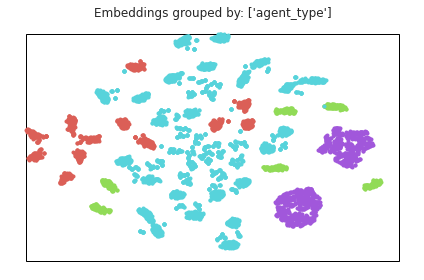

In [5]:
plot_df_embeddings(agent_specific_df, 'ttx[64,4,4]_ttx[64,4,4]_seed5', ndims=2, reduce="TSNE")

grim_trigger
mirror
mixed_trigger_pattern
wsls


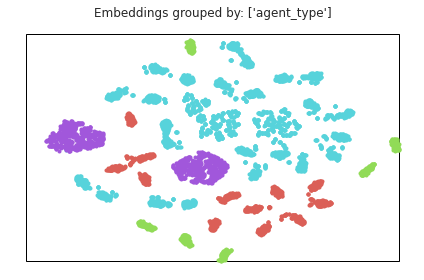

In [6]:
plot_df_embeddings(agent_specific_df, 'ttx[512,4,4]_ttx[64,4,4]_seed5', ndims=2, reduce="TSNE")

grim_trigger
mirror
mixed_trigger_pattern
wsls


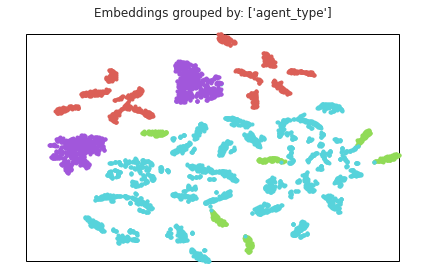

In [7]:
plot_df_embeddings(agent_specific_df, 'lstm[64,1]_lstm[64,1]_seed5', ndims=2, reduce="TSNE")

grim_trigger
mirror
mixed_trigger_pattern
wsls


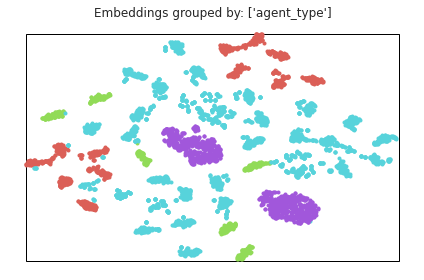

In [8]:
plot_df_embeddings(agent_specific_df, 'lstm[512,1]_lstm[64,1]_seed5', ndims=2, reduce="TSNE")

('grim_trigger', 0, nan, 0.0, 1)
('grim_trigger', 0, nan, 0.0, 2)
('grim_trigger', 0, nan, 0.0, 3)
('grim_trigger', 0, nan, 1.0, 1)
('grim_trigger', 0, nan, 1.0, 2)
('grim_trigger', 0, nan, 1.0, 3)
('grim_trigger', 1, nan, 0.0, 1)
('grim_trigger', 1, nan, 0.0, 2)
('grim_trigger', 1, nan, 0.0, 3)
('grim_trigger', 1, nan, 1.0, 1)
('grim_trigger', 1, nan, 1.0, 2)
('grim_trigger', 1, nan, 1.0, 3)
('mirror', 0, nan, nan, 1)
('mirror', 0, nan, nan, 2)
('mirror', 0, nan, nan, 3)
('mirror', 1, nan, nan, 1)
('mirror', 1, nan, nan, 2)
('mirror', 1, nan, nan, 3)
('mixed_trigger_pattern', 0, '001', 0.0, 1)
('mixed_trigger_pattern', 0, '001', 0.0, 2)
('mixed_trigger_pattern', 0, '001', 0.0, 3)
('mixed_trigger_pattern', 0, '001', 1.0, 1)
('mixed_trigger_pattern', 0, '001', 1.0, 2)
('mixed_trigger_pattern', 0, '001', 1.0, 3)
('mixed_trigger_pattern', 0, '0011', 0.0, 1)
('mixed_trigger_pattern', 0, '0011', 0.0, 2)
('mixed_trigger_pattern', 0, '0011', 0.0, 3)
('mixed_trigger_pattern', 0, '0011', 1.0, 1

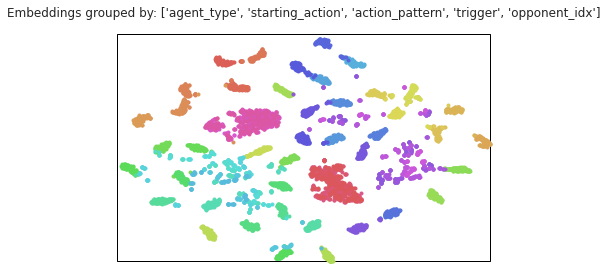

In [124]:
plot_df_embeddings(agent_specific_df, 'lstm[128,1]_lstm[64,1]_seed1', ndims=2, reduce="TSNE", 
                   label_by=['agent_type','starting_action','action_pattern','trigger','opponent_idx'])

(0, '001', 0.0, 1)
(0, '001', 0.0, 2)
(0, '001', 0.0, 3)
(0, '001', 1.0, 1)
(0, '001', 1.0, 2)
(0, '001', 1.0, 3)
(0, '0011', 0.0, 1)
(0, '0011', 0.0, 2)
(0, '0011', 0.0, 3)
(0, '0011', 1.0, 1)
(0, '0011', 1.0, 2)
(0, '0011', 1.0, 3)
(0, 'random', 0.0, 1)
(0, 'random', 0.0, 2)
(0, 'random', 0.0, 3)
(0, 'random', 1.0, 1)
(0, 'random', 1.0, 2)
(0, 'random', 1.0, 3)
(0, nan, 0.0, 1)
(0, nan, 0.0, 2)
(0, nan, 0.0, 3)
(0, nan, 1.0, 1)
(0, nan, 1.0, 2)
(0, nan, 1.0, 3)
(0, nan, nan, 1)
(0, nan, nan, 2)
(0, nan, nan, 3)
(1, '001', 0.0, 1)
(1, '001', 0.0, 2)
(1, '001', 0.0, 3)
(1, '001', 1.0, 1)
(1, '001', 1.0, 2)
(1, '001', 1.0, 3)
(1, '0011', 0.0, 1)
(1, '0011', 0.0, 2)
(1, '0011', 0.0, 3)
(1, '0011', 1.0, 1)
(1, '0011', 1.0, 2)
(1, '0011', 1.0, 3)
(1, 'random', 0.0, 1)
(1, 'random', 0.0, 2)
(1, 'random', 0.0, 3)
(1, 'random', 1.0, 1)
(1, 'random', 1.0, 2)
(1, 'random', 1.0, 3)
(1, nan, 0.0, 1)
(1, nan, 0.0, 2)
(1, nan, 0.0, 3)
(1, nan, 1.0, 1)
(1, nan, 1.0, 2)
(1, nan, 1.0, 3)
(1, nan, nan,

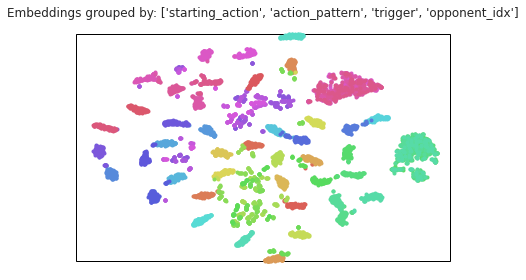

In [125]:
plot_df_embeddings(agent_specific_df, 'lstm[128,1]_lstm[64,1]_seed1', ndims=2, reduce="TSNE", 
                   label_by=['starting_action','action_pattern','trigger','opponent_idx'])

0
1


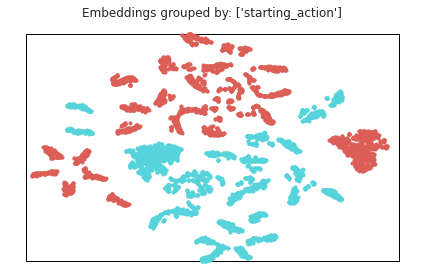

In [9]:
plot_df_embeddings(agent_specific_df, 'lstm[64,1]_lstm[64,1]_seed5', label_by="starting_action", 
                   ndims=2, reduce="TSNE")

1
2
3


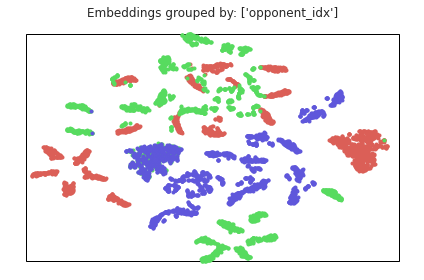

In [10]:
plot_df_embeddings(agent_specific_df, 'lstm[64,1]_lstm[64,1]_seed5', label_by="opponent_idx", 
                   ndims=2, reduce="TSNE")

grim_trigger, starting_action:0, trigger_action:0, opponent_idx:1
grim_trigger, starting_action:0, trigger_action:0, opponent_idx:2
grim_trigger, starting_action:0, trigger_action:0, opponent_idx:3
grim_trigger, starting_action:0, trigger_action:1, opponent_idx:1
grim_trigger, starting_action:0, trigger_action:1, opponent_idx:2
grim_trigger, starting_action:0, trigger_action:1, opponent_idx:3
grim_trigger, starting_action:1, trigger_action:0, opponent_idx:1
grim_trigger, starting_action:1, trigger_action:0, opponent_idx:2
grim_trigger, starting_action:1, trigger_action:0, opponent_idx:3
grim_trigger, starting_action:1, trigger_action:1, opponent_idx:1
grim_trigger, starting_action:1, trigger_action:1, opponent_idx:2
grim_trigger, starting_action:1, trigger_action:1, opponent_idx:3
mirror, starting_action:0, opponent_idx:1
mirror, starting_action:0, opponent_idx:2
mirror, starting_action:0, opponent_idx:3
mirror, starting_action:1, opponent_idx:1
mirror, starting_action:1, opponent_idx:

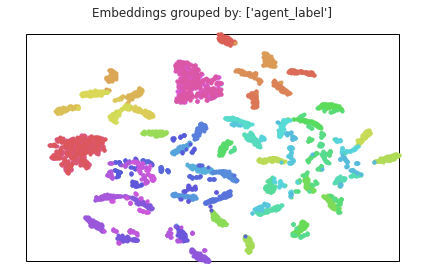

In [11]:
plot_df_embeddings(agent_specific_df, 'lstm[64,1]_lstm[64,1]_seed5', label_by=["agent_label"], 
                   ndims=2, reduce="TSNE")

1
2
3


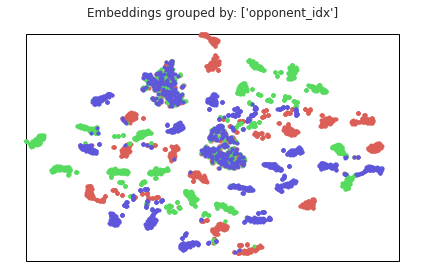

In [12]:
plot_df_embeddings(agent_specific_df, 'lstm[128,1]_lstm[64,1]_seed5', label_by=["opponent_idx"], 
                   ndims=2, reduce="TSNE")

0
1


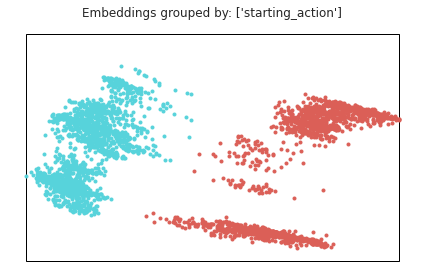

In [13]:
plot_df_embeddings(agent_specific_df, 'lstm[512,1]_lstm[64,1]_seed2', label_by=["starting_action"], 
                   agent_type="mixed_trigger_pattern", ndims=2, reduce="PCA")

0
1


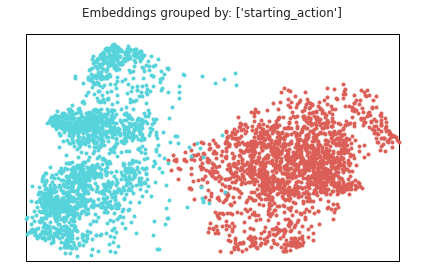

In [14]:
plot_df_embeddings(agent_specific_df, 'lstm[64,1]_lstm[64,1]_seed2', label_by=["starting_action"], 
                   agent_type="mixed_trigger_pattern", ndims=2, reduce="PCA")

1
2
3


<IPython.core.display.Javascript object>


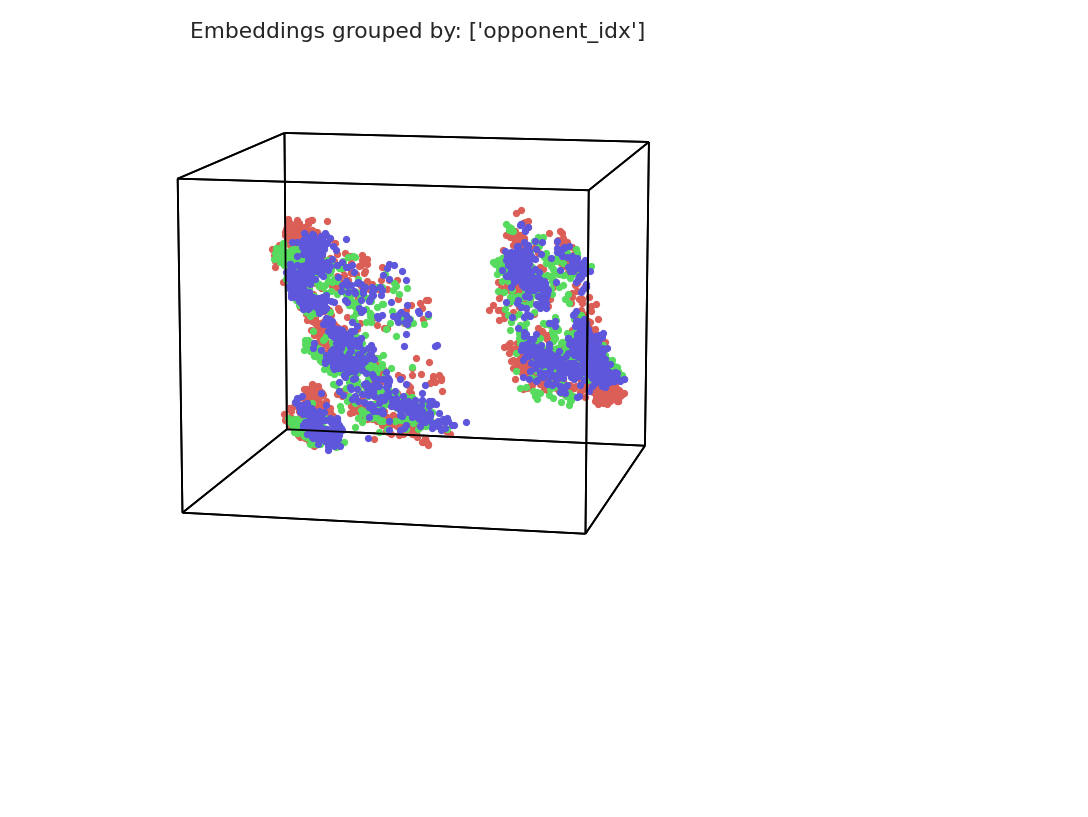

In [15]:
plot_df_embeddings(agent_specific_df, 'lstm[128,1]_lstm[64,1]_seed2', label_by="opponent_idx", 
                   ndims=3, reduce="PCA")

1
2
3


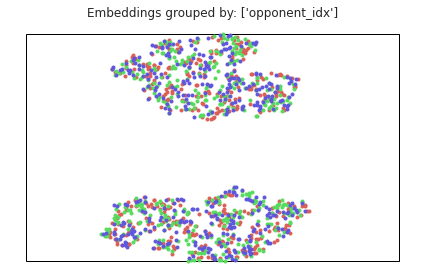

In [16]:
plot_df_embeddings(agent_specific_df, 'ttx[128,4,4]_ttx[64,4,4]_seed4', label_by="opponent_idx", 
                   ndims=2, reduce="TSNE", agent_type="wsls")

0.0
1.0


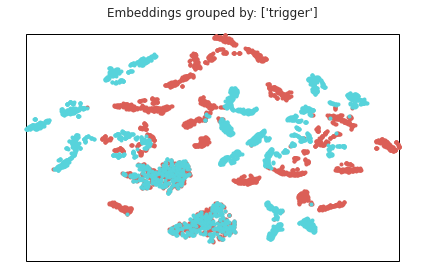

In [17]:
plot_df_embeddings(agent_specific_df, 'lstm[64,1]_lstm[64,1]_seed5', label_by="trigger", 
                   ndims=2, reduce="TSNE")

0.0
1.0


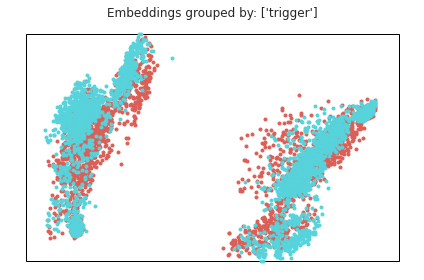

In [18]:
plot_df_embeddings(agent_specific_df, 'lstm[64,1]_lstm[64,1]_seed5', label_by="trigger", 
                   ndims=2, reduce="PCA")

(0, 1)
(0, 2)
(0, 3)
(1, 1)
(1, 2)
(1, 3)


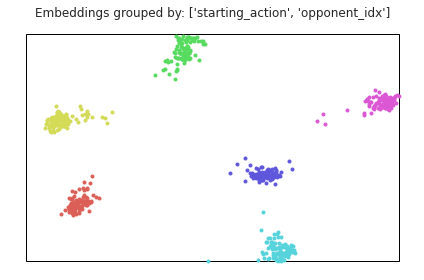

In [19]:
plot_df_embeddings(agent_specific_df, 'lstm[128,1]_lstm[64,1]_seed2', 
                   label_by=["starting_action", "opponent_idx"], agent_type="mirror", ndims=2, reduce="PCA")

0
1


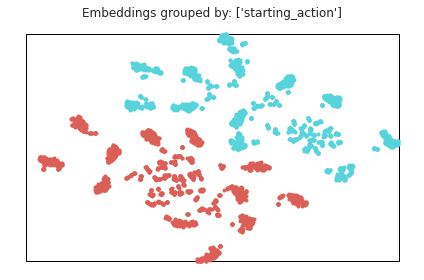

In [20]:
plot_df_embeddings(agent_specific_df, 'lstm[128,1]_lstm[64,1]_seed2', 
                   label_by=[ "starting_action"], agent_type="mixed_trigger_pattern", ndims=2, reduce="TSNE")

001
0011
random
nan


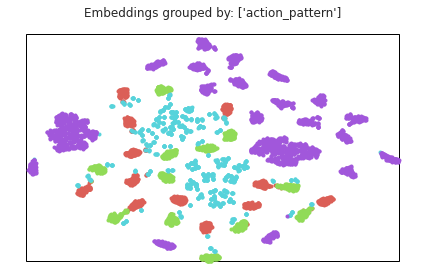

In [126]:
plot_df_embeddings(agent_specific_df, 'ttx[128,4,4]_ttx[64,4,4]_seed4', 
                   label_by="action_pattern", ndims=2, reduce="TSNE")

# Old Embedding Plot

In [21]:
# def plot_all_dfs_agent_parameter_embeddings(df_dict, metadata, dfs_names, reduce="TSNE", mask_threshold=.85, **kwargs):
#     fig, axes = plt.subplots(12, len(dfs_names), figsize=(12, 28))
    
#     for i, df_name in enumerate(dfs_names):
#         df = df_dict[df_name]["combined"]

#         plot_embeddings(df, metadata, ax=axes[0, i], label_by='starting_action', agent_type="mirror", reduce=reduce, ndims=2)
#         plot_embeddings(df, metadata, ax=axes[1, i], label_by='opponent_idx', agent_type="mirror", reduce=reduce, ndims=2)

#         plot_embeddings(df, metadata, ax=axes[2, i], label_by='starting_action', agent_type="grim_trigger", reduce=reduce, ndims=2)
#         plot_embeddings(df, metadata, ax=axes[3, i], label_by='opponent_idx', agent_type="grim_trigger", reduce=reduce, ndims=2)
#         plot_embeddings(df, metadata, ax=axes[4, i], label_by='trigger_action', agent_type="grim_trigger", reduce=reduce, ndims=2)

#         plot_embeddings(df, metadata, ax=axes[5, i], label_by='starting_action', agent_type="wsls", reduce=reduce, ndims=2)
#         plot_embeddings(df, metadata, ax=axes[6, i], label_by='opponent_idx', agent_type="wsls", reduce=reduce, ndims=2)
#         plot_embeddings(df, metadata, ax=axes[7, i], label_by='win_trigger', agent_type="wsls", reduce=reduce, ndims=2)

#         plot_embeddings(df, metadata, ax=axes[8, i], label_by='starting_action', agent_type="mixed_trigger_pattern", reduce=reduce, ndims=2)
#         plot_embeddings(df, metadata, ax=axes[9, i], label_by='opponent_idx', agent_type="mixed_trigger_pattern", reduce=reduce, ndims=2)
#         plot_embeddings(df, metadata, ax=axes[10, i], label_by='trigger_action', agent_type="mixed_trigger_pattern", reduce=reduce, ndims=2)
#         plot_embeddings(df, metadata, ax=axes[11, i], label_by='action_pattern', agent_type="mixed_trigger_pattern", reduce=reduce, ndims=2)


#     rows = ["Mirror Start Action", "Mirror Opponent", 
#             "Grim Start Action", "Grim Opponent", "Grim Trigger",
#             "WSLS Start Action", "WSLS Opponent", "WSLS Trigger",
#             "MTP Start Action", "MTP Opponent", "MTP Trigger", "MTP Action Pattern", 
#            ]
#     for ax, row in zip(axes[:,0], rows):
#         ax.axis("on")
#         ax.set_xticks([])
#         ax.set_yticks([])
#         ax.set_ylabel(row, size='large')
        
#     for row in range(len(axes)):
#         for col in range(len(axes[0])):
#             if row == 0:
#                 axes[row, col].set_title(dfs_names[col])
#             else:
#                 axes[row, col].set_title('')
    
# #     plt.suptitle(f"Embeddings label_by ({label_by}) - reduce ({reduce})")
#     plt.tight_layout()
#     plt.show()

In [22]:
# def plot_all_dfs_agent_type(df_dict, metadata, dfs_names, reduce="TSNE", mask_threshold=.85, **kwargs):
#     fig, axes = plt.subplots(1, len(dfs_names), figsize=(16, 4))
    
#     for i, df_name in enumerate(dfs_names):
#         df = df_dict[df_name]["combined"]
#         plot_embeddings(df, metadata, ax=axes[i], label_by='agent_type', reduce=reduce, ndims=2)
#         axes[i].set_title(df_name)
    
#     plt.suptitle(f"'Agent Type' Embedding Space")
#     plt.tight_layout()
#     plt.show()

In [23]:
# plot_all_dfs_agent_type(alt_lstm_lstm_dfs, metadata, ["lstm[64,1]_lstm[48,2]", "lstm[80,1]_lstm[48,2]", "lstm[80,1]_lstm[64,1]"])

In [24]:
# plot_all_dfs_agent_type(best_dfs, metadata, ["seed1", "seed2", "seed3", "seed4"])

In [25]:
# plot_all_dfs_agent_parameter_embeddings(alt_lstm_lstm_dfs, metadata, ["lstm[64,1]_lstm[48,2]", "lstm[80,1]_lstm[48,2]", "lstm[80,1]_lstm[64,1]"])

In [26]:
# plot_all_dfs_agent_parameter_embeddings(combined_dfs, metadata, ["seed1", "seed2", "seed3", "seed4"])

# create_representation_df

## debug sample

In [27]:
# def load_sample_models():
#     trained_on = "JAGrim4,JAMirror4,JAMixTgrPtrn4,JAWSLS4"

#     params = [
#               ("[128,1]", "[64,2]", list(range(1, 3))),
#               ("[80,1]", "[64,2]", list(range(1, 3))),
#               ("[80,4,4]", "[64,4,4]", list(range(1, 3))), 
#               ("[128,4,4]", "[64,4,4]", list(range(1, 3))), 
#              ]
        
#     model_dict = dict()
#     for char_params, mental_params, seeds in params:
#         if char_params.count(',') == 2:
#             char_net = "ttx"
#         else:
#             char_net = "lstm"
#         if mental_params.count(',') == 2:
#             mental_net = "ttx"
#         else:
#             mental_net = "lstm"
#         if seeds != None:
# #             multi_init_model_dict = dict()
#             for seed in seeds:
#                 modeller_dirpath = f"data/models/iterative_action/IterPastCur[{trained_on}]_{char_net}{char_params}_{mental_net}{mental_params}_seed{seed}.ckpt"
#                 model_dict[f"{char_net}{char_params}_{mental_net}{mental_params}_seed{seed}"] = load_modeller(modeller_dirpath).to("cuda")
# #                 model_dict[f"{char_net}{char_params}_{mental_net}{mental_params}_seed{seed}"] = multi_init_model_dict
#         else:
#             modeller_dirpath = f"data/models/iterative_action/IterPastCur[{trained_on}]_{char_net}{char_params}_{mental_net}{mental_params}.ckpt"
#             model_dict[f"{char_net}{char_params}_{mental_net}{mental_params}"] = load_modeller(modeller_dirpath).to("cuda")
        
#     return model_dict

In [28]:
# model_dict = load_sample_models()

In [29]:
# from tommas.analysis.representation_metrics import get_agent_specific_data, extract_model_specific_data, extract_model_param_data, append_silhouette_scores_to_df, \
#     aggregate_model_specific_data, append_final_embedding_similarity, append_pca_dims_to_df, append_model_specific_param_scores, \
#     aggregate_model_param_data, append_representation_similarity_over_diff_init, extract_architecture_data, \
#     generate_random_traj, _get_model_prediction_data, get_param_silhouette_and_dim

In [30]:
# def get_traj_cluster(sa, ta, n=25):
#     trajs = []
#     seed = 42
#     for _ in range(n):
#         trajs.append(generate_random_traj("grim_trigger", {"starting_action": sa, "trigger_action": ta}, seed=seed, num_agents=4, opponent_idx=1, n_past=5))
#         seed += 1
#     return trajs
        
# def get_traj_embeddings(models_dict, n=25):
#     data = []
#     for sa in [0, 1]:
#         for ta in [0, 1]:
#             for model_name in models_dict:
#                 trajs = get_traj_cluster(sa, ta, n)
#                 char_embeddings, losses, accs = _get_model_prediction_data(models_dict[model_name], trajs)
#                 char_embedding = char_embeddings[:, -1]
#                 loss = losses[-1]
#                 acc = accs[-1]
#                 data.append({"model_name": model_name, "starting_action": sa, 
#                              "trigger": ta, "char_embedding": char_embedding,
#                              "loss": loss, "acc": acc})
#     return pd.DataFrame(data)
                
                    

In [31]:
# embeddings_df = get_traj_embeddings(model_dict)

In [32]:
# def get_threshold_df(embeddings_df):
#     scores = []
#     for threshold in reversed([.1, .2, .3, .4, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95]):
#         filtered_silhouette_scores = []
#         silhouette_scores = []
#         dims = []
#         filtered_dims = []
#         for model_name, model_df in embeddings_df.groupby("model_name"):
#             model_df
#             agent_params = ["starting_action", "trigger"]
#             for agent_param in agent_params:
#                 labels = []
#                 embeddings = []
#                 for i, group_embeddings in enumerate(
#                         model_df.groupby(agent_param)["char_embedding"].apply(lambda a: np.vstack(a))):
#                     labels = labels + [i for _ in range(group_embeddings.shape[0])]
#                     embeddings.append(group_embeddings)
#                 param_embeddings = np.concatenate(embeddings, axis=0)
#                 param_labels = np.array(labels)
#         #         print(param_labels)
#         #         with np.printoptions(precision=3, suppress=True):
#         #             for a in [(x[:5], y) for (x, y) in zip(param_embeddings, param_labels)]:
#         #                 print(f"{a[0]}, {a[1]}")

#                 for _ in range(5):
#                     silhouette, feature_dim = get_param_silhouette_and_dim(param_embeddings, param_labels, threshold)
#                     silhouette_scores.append(silhouette)
#                     dims.append(feature_dim)
#                     if silhouette > -1:
#                         filtered_silhouette_scores.append(silhouette)
#                         filtered_dims.append(feature_dim)
#         mean_sil = np.mean(silhouette_scores)
#         mean_fil_sil = np.mean(filtered_silhouette_scores)
#         mean_dims = np.mean(dims)
#         mean_fil_dims = np.mean(filtered_dims)
#         data_point = {"threshold": threshold, 
#                        "silhouette": -1 if np.isnan(mean_sil) else mean_sil,
#                        "filtered_silhouette": -1 if np.isnan(mean_fil_sil) else mean_fil_sil,
#                        "dim": -1 if np.isnan(mean_dims) else mean_dims,
#                        "filtered_dim": -1 if np.isnan(mean_fil_dims) else mean_fil_dims}
#         print(data_point)
#         scores.append(data_point)
            
#     return pd.DataFrame(scores)

# #         print(model_name, silhouette, feature_dim)

In [33]:
# threshold_df = get_threshold_df(embeddings_df)

In [34]:
# threshold_df = pd.DataFrame([{'threshold': 0.95, 'silhouette': -0.8178353702649475, 'filtered_silhouette': 0.21443088, 'dim': 0.925, 'filtered_dim': 6.166666666666667},
# {'threshold': 0.9, 'silhouette': -0.33337377607822416, 'filtered_silhouette': 0.36743844, 'dim': 1.9, 'filtered_dim': 3.8974358974358974},
# {'threshold': 0.85, 'silhouette': -0.06690109502524137, 'filtered_silhouette': 0.4084512, 'dim': 2.7625, 'filtered_dim': 4.169811320754717},
# {'threshold': 0.8, 'silhouette': 0.01900736759416759, 'filtered_silhouette': 0.4301858, 'dim': 3.8125, 'filtered_dim': 5.350877192982456},
# {'threshold': 0.75, 'silhouette': 0.11791048920713365, 'filtered_silhouette': 0.44246516, 'dim': 4.0, 'filtered_dim': 5.161290322580645},
# {'threshold': 0.7, 'silhouette': 0.14470119971665554, 'filtered_silhouette': 0.4308765, 'dim': 5.1875, 'filtered_dim': 6.484375},
# {'threshold': 0.65, 'silhouette': 0.24809350434370572, 'filtered_silhouette': 0.40630248, 'dim': 6.5875, 'filtered_dim': 7.422535211267606},
# {'threshold': 0.6, 'silhouette': 0.3149279783348902, 'filtered_silhouette': 0.38413468, 'dim': 10.275, 'filtered_dim': 10.81578947368421},
# {'threshold': 0.55, 'silhouette': 0.35153595680603755, 'filtered_silhouette': 0.36864403, 'dim': 15.9625, 'filtered_dim': 16.164556962025316},
# {'threshold': 0.5, 'silhouette': 0.3613347, 'filtered_silhouette': 0.3613347, 'dim': 31.5625, 'filtered_dim': 31.5625},
# {'threshold': 0.4, 'silhouette': 0.35709924, 'filtered_silhouette': 0.35709924, 'dim': 61.1625, 'filtered_dim': 61.1625},
# {'threshold': 0.3, 'silhouette': 0.3468446, 'filtered_silhouette': 0.3468446, 'dim': 71.2625, 'filtered_dim': 71.2625},
# {'threshold': 0.2, 'silhouette': 0.343344, 'filtered_silhouette': 0.343344, 'dim': 76.025, 'filtered_dim': 76.025},
# {'threshold': 0.1, 'silhouette': 0.3278319, 'filtered_silhouette': 0.3278319, 'dim': 84.175, 'filtered_dim': 84.175},
# ])

In [35]:
# threshold_df

## look at data

### Correlation

In [22]:
calculate_and_combine_model_corr(model_specific_df, calculate_model_specific_corr, n_past=5)

/home/kane0058/Documents/TOMMAS/venv/lib/python3.6/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kane0058/Documents/TOMMAS/venv/lib/python3.6/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,,char_embedding_size_lstm,char_embedding_size_ttx
char_embedding_size,,1.0***,1.0***
loss,mean,-0.22,0.84***
acc,mean,0.26,-0.75***
cluster_silhouette_score,mean,-0.36,-0.49*
modified_cluster_silhouette_score,mean,-0.14,0.54**
final_embedding_similarity,,0.37,-0.25
final_embedding_distance,,nan,nan
final_embedding_euclidean_similarity,,nan,nan
final_embedding_euclidean_similarity_norm,,nan,nan
final_embedding_cosine_similarity,,-0.58**,0.5*


In [23]:
calculate_and_combine_model_corr(model_param_df, calculate_model_param_corr, agg_metric="mean", n_past=5)

,,char_embedding_size_lstm,char_embedding_size_ttx
char_embedding_size,,1.0***,1.0***
diff_init_similarity_score,mean,1.0***,-0.94


In [24]:
for i in calculate_and_combine_model_corr(model_specific_df, calculate_model_specific_corr).iterrows():
    label = ' '.join(i[0][0].split('_'))
    print(label, '&', i[1]["char_embedding_size_lstm"], '&', i[1]["char_embedding_size_ttx"], "\\\\")

char embedding size & 1.0*** & 1.0*** \\
loss & -0.22 & 0.84*** \\
acc & 0.26 & -0.75*** \\
cluster silhouette score & -0.36 & -0.49* \\
modified cluster silhouette score & -0.14 & 0.54** \\
final embedding similarity & 0.37 & -0.25 \\
final embedding distance & nan & nan \\
final embedding euclidean similarity & nan & nan \\
final embedding euclidean similarity norm & nan & nan \\
final embedding cosine similarity & -0.58** & 0.5* \\
pca 50% & 1.0*** & 0.66*** \\
pca 75% & 1.0*** & 0.87*** \\
pca 80% & 1.0*** & 0.91*** \\
pca 90% & 1.0*** & 0.95*** \\
starting action score & 0.57** & 0.75*** \\
starting action dim & 0.76*** & -0.37 \\
trigger score & 0.36 & 0.43 \\
trigger dim & -0.2 & 0.27 \\
action pattern score & 0.75*** & 0.5* \\
action pattern dim & -0.23 & 0.39 \\
opponent idx score & 0.15 & -0.59** \\
opponent idx dim & 0.22 & 0.3 \\
shared starting action score & 0.63** & 0.79*** \\
shared starting action dim & nan & -0.29 \\
shared trigger score & 0.23 & 0.38 \\
shared trigge

/home/kane0058/Documents/TOMMAS/venv/lib/python3.6/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kane0058/Documents/TOMMAS/venv/lib/python3.6/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


### Performance Metrics

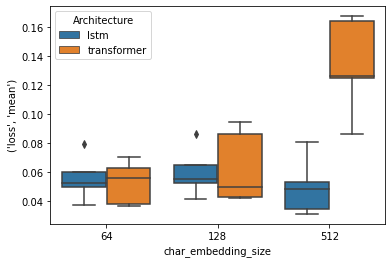

In [25]:
lstm_ttx_boxplot_comparison(model_specific_df, "loss")

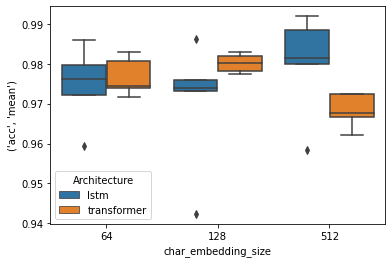

In [26]:
lstm_ttx_boxplot_comparison(model_specific_df, "acc")

### DCI

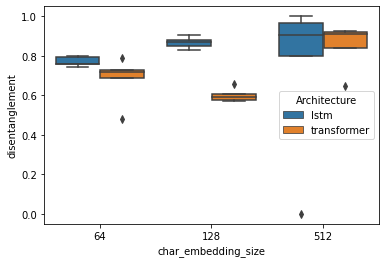

In [27]:
lstm_ttx_boxplot_comparison(model_specific_df, "disentanglement")

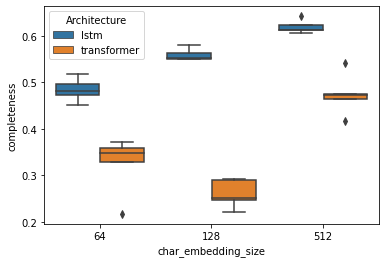

In [28]:
lstm_ttx_boxplot_comparison(model_specific_df, "completeness")

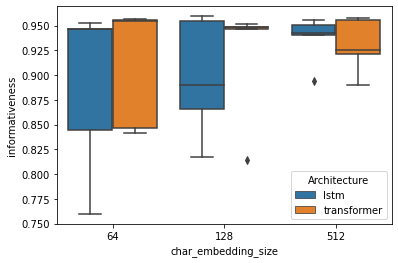

In [29]:
lstm_ttx_boxplot_comparison(model_specific_df, "informativeness")

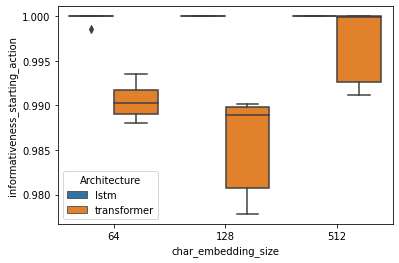

In [30]:
lstm_ttx_boxplot_comparison(model_specific_df, "informativeness_starting_action")

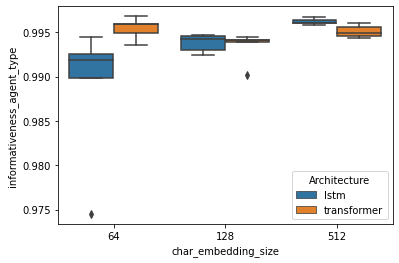

In [31]:
lstm_ttx_boxplot_comparison(model_specific_df, "informativeness_agent_type")

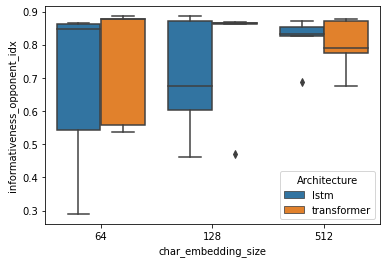

In [32]:
lstm_ttx_boxplot_comparison(model_specific_df, "informativeness_opponent_idx")

### Cluster

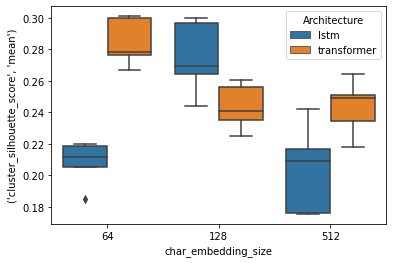

In [33]:
lstm_ttx_boxplot_comparison(model_specific_df, "cluster_silhouette_score")

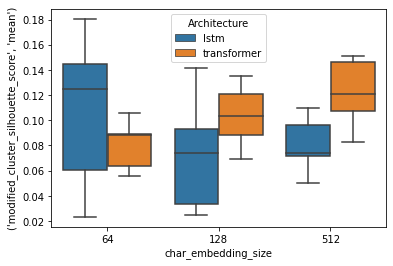

In [34]:
lstm_ttx_boxplot_comparison(model_specific_df, "modified_cluster_silhouette_score")

### PCA

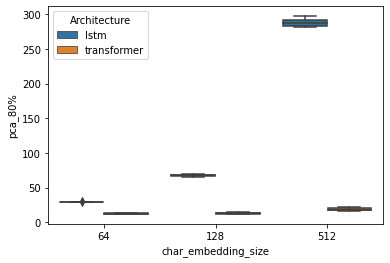

In [35]:
lstm_ttx_boxplot_comparison(model_specific_df, "pca_80%")

### Convergence

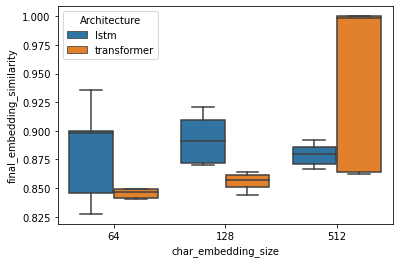

In [4]:
lstm_ttx_boxplot_comparison(model_specific_df, "final_embedding_similarity", n_past=1)

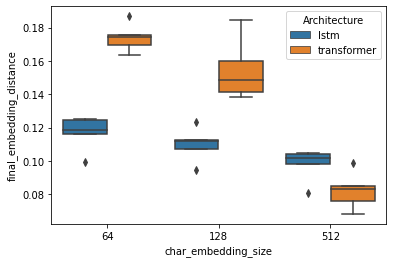

In [5]:
lstm_ttx_boxplot_comparison(model_specific_df, "final_embedding_distance", n_past=1)

In [6]:
def calculate_final_embedding_convergence(df):
    def riemann_sum(n_past_values):
        dx = 1
        midpoints = (n_past_values[:-1] + n_past_values[1:]) / 2
        return np.sum(midpoints*dx) / len(n_past_values)
    
    sim_convg = []
    dist_convg = []
    data = []
    for (model_name, model_df) in df[["model_name", "char_embedding_size", "lstm_char", "n_past", "final_embedding_similarity", "final_embedding_distance"]].groupby(["model_name"]):
        char_embedding_size = model_df.char_embedding_size.iloc[0]
        lstm_char = model_df.lstm_char.iloc[0]
        similarities = np.array(model_df["final_embedding_similarity"].tolist())
        distances = np.array(model_df["final_embedding_distance"].tolist())
        data.append({"char_embedding_size": char_embedding_size, 
                     "Architecture": ("lstm" if lstm_char else "transformer"), 
                     "npast_1_sim": similarities[1],
                     "npast_1_dist": distances[1],
                     "similarity_convergence": riemann_sum(similarities), 
                     "distance_convergence": riemann_sum(distances) / max(distances),})
        
    convg_df = pd.DataFrame(data)
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    sns.boxplot(x=convg_df["char_embedding_size"],
                y=convg_df["similarity_convergence"],
                hue=convg_df["Architecture"],
                ax=axes[0])
    sns.boxplot(x=convg_df["char_embedding_size"],
                y=convg_df["distance_convergence"],
                hue=convg_df["Architecture"],
                ax=axes[1])
    plt.show()
#     print("lstm")
#     print(calculate_df_corr(convg_df[convg_df["Architecture"] == "lstm"]))
#     print("ttx")
#     print(calculate_df_corr(convg_df[convg_df["Architecture"] == "transformer"]))


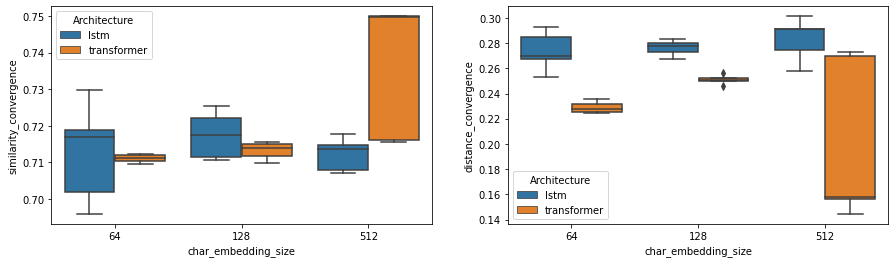

In [7]:
calculate_final_embedding_convergence(model_specific_df)

### Stability

#### Different Initialization

<AxesSubplot:xlabel='char_embedding_size', ylabel="('diff_init_similarity_score', 'mean')">

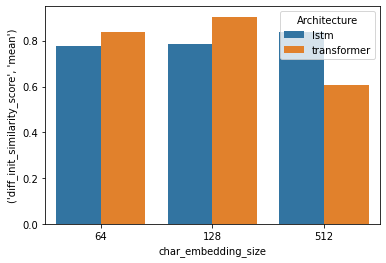

In [40]:
diff_init = model_param_df.copy()
diff_init['Architecture'] = np.where(diff_init['lstm_char'] == True, "lstm", "transformer")
sns.barplot(x="char_embedding_size", y=("diff_init_similarity_score", "mean"), data=diff_init[diff_init["n_past"] == 5], hue="Architecture")

#### Different Parameterization

<AxesSubplot:xlabel='Architecture', ylabel="('architecture_similarity_score', 'mean')">

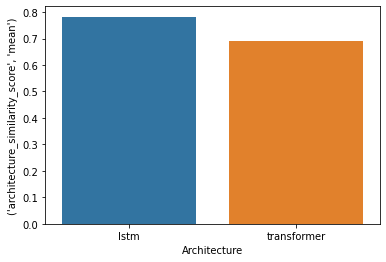

In [41]:
diff_param = architecture_df.copy()
diff_param['Architecture'] = np.where(diff_param['lstm_char'] == True, "lstm", "transformer")
sns.barplot(x="Architecture", y=("architecture_similarity_score", "mean"), data=diff_param[diff_param["n_past"] == 5], order=["lstm", "transformer"])
# sns.barplot(x=, y=("architecture_similarity_score", "mean"), data=diff_param)


In [42]:
architecture_df[architecture_df["n_past"] == 5]

lstm_char lstm_mental n_past  loss                                          \
                                count      mean       std       min       25%   
5      False       False      5  66.0  0.083183  0.181808  0.000001  0.000121   
11      True        True      5  66.0  0.055051  0.116928  0.000082  0.001867   

                        ... completeness informativeness  \
         50%       75%  ...                                
5   0.000938  0.004143  ...     0.353122        0.920872   
11  0.004402  0.012372  ...     0.554122        0.908033   

   architecture_similarity_score                                          \
                           count      mean       std       min       25%   
5                           1050  0.691649  0.250665  0.270166  0.270166   
11                          1050  0.782455  0.039989  0.686175  0.686175   

                                  
         50%       75%       max  
5   0.270166  0.270166  0.999873  
11  0.686176  0.686176  0.875488  

[2 rows x 129 columns]

In [43]:
def get_cross_embedding_representation_similarity(df, cross_type="architecture"):
    import re

    def atoi(text):
        return int(text) if text.isdigit() else text

    def natural_keys(text):
        '''
        alist.sort(key=natural_keys) sorts in human order
        http://nedbatchelder.com/blog/200712/human_sorting.html
        (See Toothy's implementation in the comments)
        '''
        return [ atoi(c) for c in re.split(r'(\d+)', text) ]
    
    def get_avg_sim_scores(embeddings_a, embeddings_b):
        sim_scores = []
        for embeddings in itertools.product(embeddings_a, embeddings_b):
            _, indiv_sim_scores = get_representation_similarity_score(embeddings, similarity="cka")
            sim_scores.append(indiv_sim_scores)
        return np.average(sim_scores)
    
    def get_cross_embedding_sim_matrix(df_a, df_b, families_a, families_b):
        sim_matrix = np.zeros((len(families_a), len(families_b)))
        for i, family_a in enumerate(families_a):
            for j, family_b in enumerate(families_b):
                embeddings_a = df_a[family_a].groupby(["model_seed"])["char_embedding"].apply(
                    lambda a: np.vstack(a)).tolist()
                embeddings_b = df_b[family_b].groupby(["model_seed"])["char_embedding"].apply(
                    lambda a: np.vstack(a)).tolist()
                sim_matrix[i, j] = get_avg_sim_scores(embeddings_a, embeddings_b)
        return sim_matrix
    
    def plot_sim_matrix(sim_matrix, ax, row_families, col_families):
        ax.imshow(sim_matrix, cmap="hot", interpolation="nearest", vmin=0., vmax=1.0)
#         for i in range(len(strategy_order)):
#             for j in range(len(strategy_order)):
#                 text = plt.text(j, i, "{:.2f}".format(sim_matrix[i, j]), ha="center", va="center", color="b")
#         ax.set_xticks(len(col_families))
        ax.set_xticks(range(len(col_families)))
        ax.set_xticklabels(col_families, rotation=90)
        ax.set_yticks(range(len(row_families)))
        ax.set_yticklabels(row_families)

    lstm_embedding_df = df[(df["lstm_char"] == True)][["model_family", "model_seed", "n_past", "char_embedding"]]
    ttx_embedding_df = df[(df["lstm_char"] == False)][["model_family", "model_seed", "n_past", "char_embedding"]]
    lstm_families = lstm_embedding_df["model_family"].unique().tolist()
    lstm_families.sort(key=natural_keys)
    ttx_families = ttx_embedding_df["model_family"].unique().tolist()
    ttx_families.sort(key=natural_keys)
    for n_p in [5]:
        lstm_past_df = lstm_embedding_df[lstm_embedding_df["n_past"] == n_p]
        ttx_past_df = ttx_embedding_df[ttx_embedding_df["n_past"] == n_p]
        lstm_dfs = dict(tuple(lstm_past_df.groupby(["model_family"])))
        ttx_dfs = dict(tuple(ttx_past_df.groupby(["model_family"])))

        print("Arch")
        fig, ax = plt.subplots()
        sim_matrix = get_cross_embedding_sim_matrix(lstm_dfs, ttx_dfs, lstm_families, ttx_families)
        plot_sim_matrix(sim_matrix, ax, lstm_families, ttx_families)
        plt.show()
        print(f"min: {np.min(sim_matrix)}, max: {np.max(sim_matrix)}, avg: {np.mean(sim_matrix)}")
            
        print("LSTM")
        fig, ax = plt.subplots()
        sim_matrix = get_cross_embedding_sim_matrix(lstm_dfs, lstm_dfs, lstm_families, lstm_families)
        plot_sim_matrix(sim_matrix, ax, lstm_families, lstm_families)
        plt.show()
        print(f"min: {np.min(sim_matrix)}, max: {np.max(sim_matrix)}, avg: {np.mean(sim_matrix)}")
        
        print("TTX")
        fig, ax = plt.subplots()
        sim_matrix = get_cross_embedding_sim_matrix(ttx_dfs, ttx_dfs, ttx_families, ttx_families)
        plot_sim_matrix(sim_matrix, ax, ttx_families, ttx_families)
        plt.show()
        print(f"min: {np.min(sim_matrix)}, max: {np.max(sim_matrix)}, avg: {np.mean(sim_matrix)}")


Arch


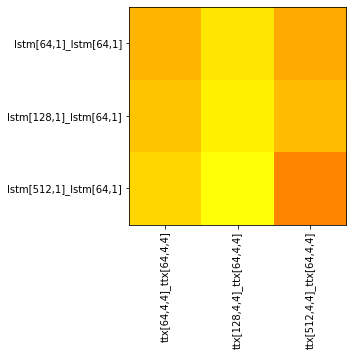

min: 0.5642852368201703, max: 0.750001203991948, avg: 0.6659295415391576
LSTM


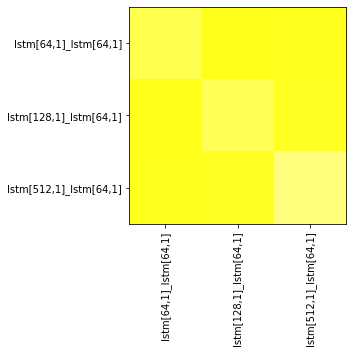

min: 0.7703859216636283, max: 0.8708943166194054, avg: 0.7969583069402479
TTX


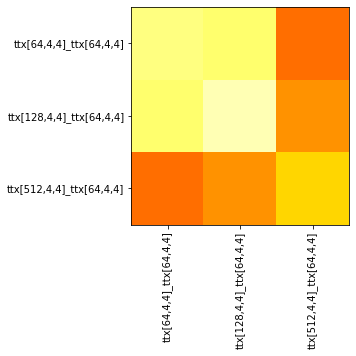

min: 0.5297002109848408, max: 0.9236656628738893, avg: 0.7122059709997439


In [44]:
get_cross_embedding_representation_similarity(agent_specific_df)

### Agent Params

#### Shared

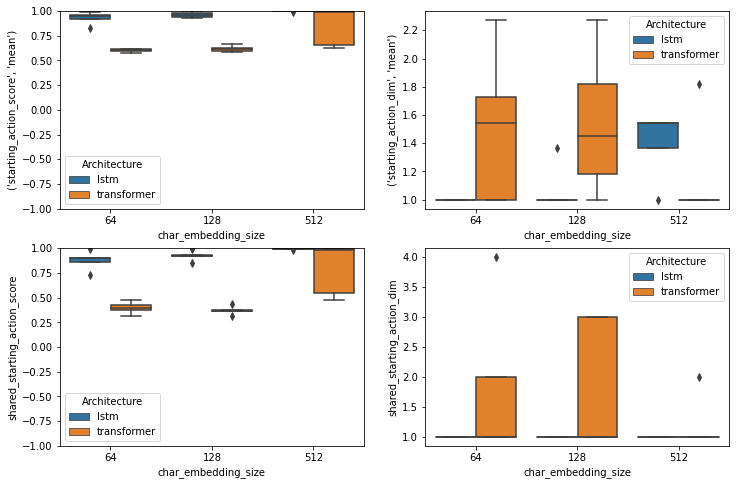

In [45]:
lstm_ttx_agent_param_boxplot_comparison(model_specific_df, "starting_action", compare="shared")

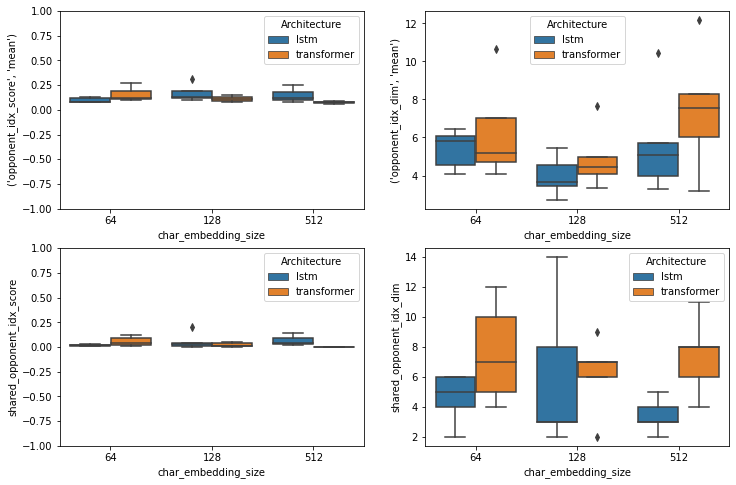

In [46]:
lstm_ttx_agent_param_boxplot_comparison(model_specific_df, "opponent_idx", compare="shared")

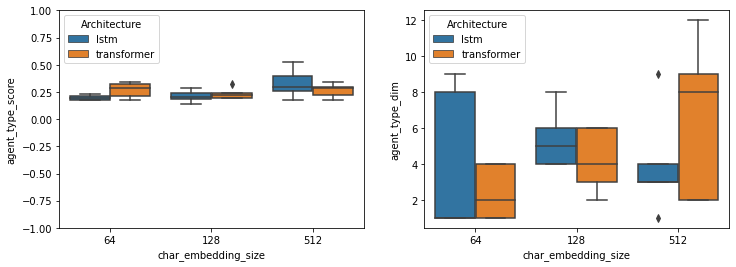

In [47]:
lstm_ttx_agent_param_boxplot_comparison(model_specific_df, "agent_type")

#### Individual

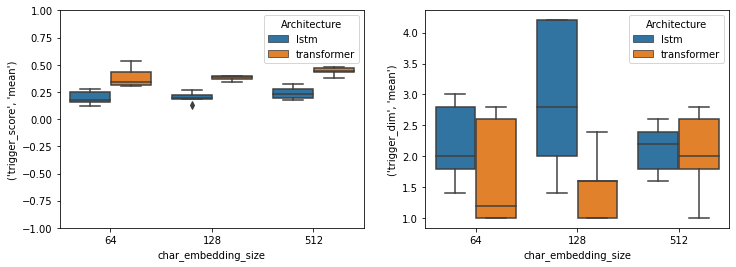

In [48]:
lstm_ttx_agent_param_boxplot_comparison(model_specific_df, "trigger")

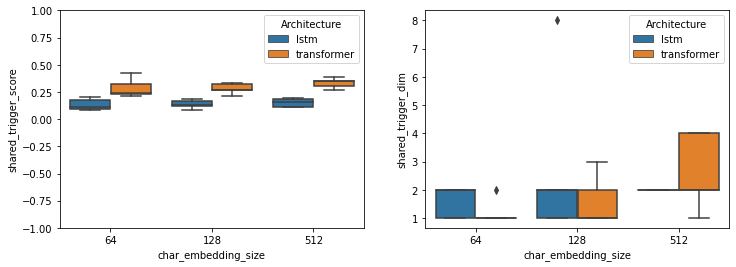

In [139]:
lstm_ttx_agent_param_boxplot_comparison(model_specific_df, "shared_trigger")

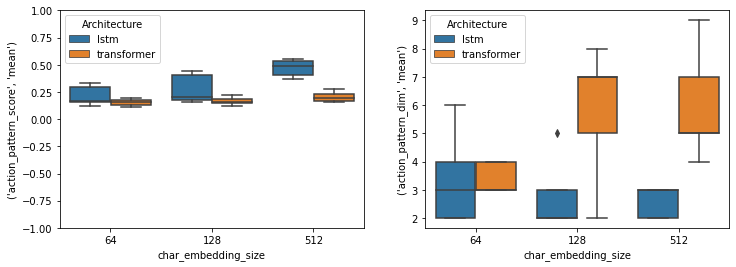

In [49]:
lstm_ttx_agent_param_boxplot_comparison(model_specific_df, "action_pattern")

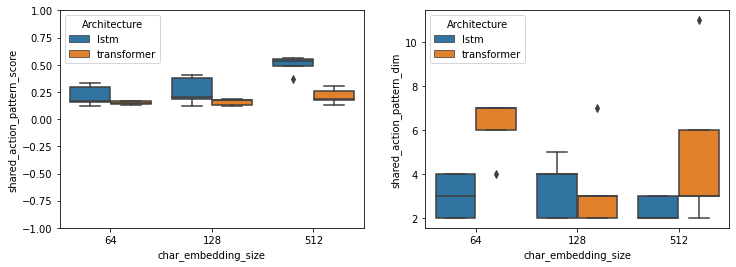

In [140]:
lstm_ttx_agent_param_boxplot_comparison(model_specific_df, "shared_action_pattern")

In [60]:
def append_modified_silhouette_scores_to_df(agent_specific_df):
    data = []
    models_names = agent_specific_df["model_name"].unique()
    for model_name in models_names:
#         all_labels_and_embeddings = agent_specific_df[agent_specific_df["model_name"] == model_name][
#             ["agent_type", "starting_action", "action_pattern", "trigger", "n_past", "char_embedding"]]
        all_labels_and_embeddings = agent_specific_df[agent_specific_df["model_name"] == model_name][
            ["agent_type", "starting_action", "action_pattern", "trigger", "opponent_idx", "n_past", "char_embedding"]]
        for n_past in range(6):
            all_embeddings = []
            labels = []
            group_labels = []
#             for (agent_type, starting_action, action_pattern, trigger), df in all_labels_and_embeddings.groupby(
#                     ["agent_type", "starting_action", "action_pattern", "trigger"]):
#                 modified_label = agent_type + str(starting_action) + action_pattern + str(trigger)
#                 group_labels.append((agent_type, starting_action, action_pattern, trigger))
#                 embeddings = np.concatenate(df[df["n_past"] == n_past]["char_embedding"].tolist())
#                 all_embeddings.append(embeddings)
#                 num_embed_per_cluster = embeddings.shape[0]
#                 labels.append(np.repeat(modified_label, num_embed_per_cluster))
#             embeddings = np.concatenate(all_embeddings, axis=0)
#             labels = np.concatenate(labels)
#             samples = silhouette_samples(embeddings, labels)
#             for i, (agent_type, starting_action, action_pattern, trigger) in enumerate(group_labels):
#                 idx = num_embed_per_cluster * i
#                 label_average = np.average(samples[idx:idx + num_embed_per_cluster])
#                 print(label_average)
#                 data.append({"model_name": model_name,
#                              "n_past": n_past,
#                              "agent_type": agent_type,
#                              "starting_action": starting_action,
#                              "action_pattern": action_pattern,
#                              "trigger": trigger,
#                              "new_modified_cluster_silhouette_score": label_average})
            for (agent_type, starting_action, action_pattern, trigger, opponent_idx), df in all_labels_and_embeddings.groupby(
                    ["agent_type", "starting_action", "action_pattern", "trigger", "opponent_idx"]):
                modified_label = agent_type + str(starting_action) + action_pattern + str(trigger) + str(opponent_idx)
                group_labels.append((agent_type, starting_action, action_pattern, trigger, opponent_idx))
                embeddings = np.concatenate(df[df["n_past"] == n_past]["char_embedding"].tolist())
                all_embeddings.append(embeddings)
                num_embed_per_cluster = embeddings.shape[0]
                labels.append(np.repeat(modified_label, num_embed_per_cluster))
            embeddings = np.concatenate(all_embeddings, axis=0)
            labels = np.concatenate(labels)
            samples = silhouette_samples(embeddings, labels)
            for i, (agent_type, starting_action, action_pattern, trigger, opponent_idx) in enumerate(group_labels):
                idx = num_embed_per_cluster * i
                label_average = np.average(samples[idx:idx + num_embed_per_cluster])
                print(label_average)
                data.append({"model_name": model_name,
                             "n_past": n_past,
                             "agent_type": agent_type,
                             "starting_action": starting_action,
                             "action_pattern": action_pattern,
                             "trigger": trigger,
                             "opponent_idx": opponent_idx,
                             "new_modified_cluster_silhouette_score": label_average})
    raise ValueError

    return agent_specific_df.merge(pd.DataFrame(data), how="left",
                                   on=["model_name", "n_past", "agent_type", "starting_action", "action_pattern", "trigger"])

In [128]:
from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


def get_best_silhouette_scores_to_df(agent_specific_df, n_past=5):
    dfs = []
    models_names = agent_specific_df["model_name"].unique()
    sets = powerset(["agent_type", "starting_action", "action_pattern", "trigger", "opponent_idx"])
    for params in sets:
        if len(params) == 0:
            continue
        print('testing params', params)
        data = []
        for model_name in models_names:
            all_labels_and_embeddings = agent_specific_df[agent_specific_df["model_name"] == model_name][
                ["agent_type", "starting_action", "action_pattern", "trigger", "opponent_idx", "n_past", "char_embedding"]]
            all_embeddings = []
            labels = []
            group_labels = []
            for param_var, df in all_labels_and_embeddings.groupby([*params], dropna=False):
                if type(param_var) == tuple:
                    modified_label = ','.join([str(v) for v in param_var])
                else:
                    modified_label = str(param_var)
                group_labels.append(param_var)
                embeddings = np.concatenate(df[df["n_past"] == n_past]["char_embedding"].tolist())
                all_embeddings.append(embeddings)
                num_embed_per_cluster = embeddings.shape[0]
                labels.append(np.repeat(modified_label, num_embed_per_cluster))
            embeddings = np.concatenate(all_embeddings, axis=0)
            labels = np.concatenate(labels)
            samples = silhouette_score(embeddings, labels)
            param_name = ','.join(params)
            lstm_char = True
            if "ttx" in model_name:
                lstm_char = False
                
            embedding_size = 64
            if "128" in model_name:
                embedding_size = 128
            if "512" in model_name:
                embedding_size = 512
            
#             print(model_name, param_name, samples)
            data.append({"model_name": model_name,
                         "char_embedding_size": embedding_size,
                         "lstm_char": lstm_char,
                         "n_past": 5,
                          param_name: samples})
        dfs.append(pd.DataFrame(data))
    import functools as ft
    return ft.reduce(lambda left, right: pd.merge(left, right, on=['model_name', "char_embedding_size",
                                                                  "lstm_char", "n_past"]), dfs)
#     return pd.DataFrame(data)
#                 for i, (agent_type, starting_action, action_pattern, trigger, opponent_idx) in enumerate(group_labels):
#                     idx = num_embed_per_cluster * i
#                     label_average = np.average(samples[idx:idx + num_embed_per_cluster])
#                     print(label_average)
#                     data.append({"model_name": model_name,
#                                  "n_past": n_past,
#                                  "agent_type": agent_type,
#                                  "starting_action": starting_action,
#                                  "action_pattern": action_pattern,
#                                  "trigger": trigger,
#                                  "opponent_idx": opponent_idx,
#                                  "new_modified_cluster_silhouette_score": label_average})
#     raise ValueError

#     return agent_specific_df.merge(pd.DataFrame(data), how="left",
#                                    on=["model_name", "n_past", "agent_type", "starting_action", "action_pattern", "trigger"])

In [129]:
sil_df = get_best_silhouette_scores_to_df(agent_specific_df)

testing params ('agent_type',)
testing params ('starting_action',)
testing params ('action_pattern',)
testing params ('trigger',)
testing params ('opponent_idx',)
testing params ('agent_type', 'starting_action')
testing params ('agent_type', 'action_pattern')
testing params ('agent_type', 'trigger')
testing params ('agent_type', 'opponent_idx')
testing params ('starting_action', 'action_pattern')
testing params ('starting_action', 'trigger')
testing params ('starting_action', 'opponent_idx')
testing params ('action_pattern', 'trigger')
testing params ('action_pattern', 'opponent_idx')
testing params ('trigger', 'opponent_idx')
testing params ('agent_type', 'starting_action', 'action_pattern')
testing params ('agent_type', 'starting_action', 'trigger')
testing params ('agent_type', 'starting_action', 'opponent_idx')
testing params ('agent_type', 'action_pattern', 'trigger')
testing params ('agent_type', 'action_pattern', 'opponent_idx')
testing params ('agent_type', 'trigger', 'opponent

In [130]:
sil_df

,model_name,char_embedding_size,lstm_char,n_past,agent_type,starting_action,action_pattern,trigger,opponent_idx,"agent_type,starting_action",...,"starting_action,action_pattern,trigger","starting_action,action_pattern,opponent_idx","starting_action,trigger,opponent_idx","action_pattern,trigger,opponent_idx","agent_type,starting_action,action_pattern,trigger","agent_type,starting_action,action_pattern,opponent_idx","agent_type,starting_action,trigger,opponent_idx","agent_type,action_pattern,trigger,opponent_idx","starting_action,action_pattern,trigger,opponent_idx","agent_type,starting_action,action_pattern,trigger,opponent_idx"
0,"lstm[128,1]_lstm[64,1]_seed1",128,True,5,0.094053,0.214855,0.111393,0.022687,0.025772,0.248681,...,0.107881,0.081934,0.088781,0.105441,0.126160,0.137846,0.215195,0.120396,0.241919,0.296827
1,"lstm[128,1]_lstm[64,1]_seed2",128,True,5,0.078840,0.236592,0.065286,0.036188,0.020089,0.214203,...,0.118271,0.061908,0.102183,0.076456,0.123311,0.101652,0.201804,0.091648,0.214422,0.269582
2,"lstm[128,1]_lstm[64,1]_seed3",128,True,5,0.078526,0.166892,0.080623,0.030418,0.008861,0.189113,...,0.101742,0.032576,0.064744,0.073285,0.116837,0.068694,0.160442,0.090941,0.190694,0.243975
3,"lstm[128,1]_lstm[64,1]_seed4",128,True,5,0.106337,0.167172,0.073562,0.029034,0.016218,0.216083,...,0.091474,0.057209,0.091078,0.093147,0.109252,0.101606,0.219481,0.112544,0.209598,0.264574
4,"lstm[128,1]_lstm[64,1]_seed5",128,True,5,0.086120,0.174735,0.088642,0.032617,0.035278,0.226735,...,0.105119,0.077733,0.100363,0.099125,0.125520,0.139943,0.219656,0.116219,0.246358,0.300026
5,"lstm[512,1]_lstm[64,1]_seed1",512,True,5,0.082616,0.130726,0.110100,0.034823,0.018386,0.190524,...,0.093111,0.047686,0.072329,0.088244,0.112092,0.077230,0.166586,0.101204,0.167741,0.208838
6,"lstm[512,1]_lstm[64,1]_seed2",512,True,5,0.092106,0.146791,0.090935,0.031544,0.016845,0.211708,...,0.087189,0.035001,0.074928,0.072624,0.104974,0.066173,0.158008,0.082562,0.143426,0.175496
7,"lstm[512,1]_lstm[64,1]_seed3",512,True,5,0.093789,0.135301,0.070328,0.037760,0.025278,0.190636,...,0.082542,0.043587,0.059214,0.068719,0.092978,0.074223,0.148578,0.084550,0.139994,0.176041
8,"lstm[512,1]_lstm[64,1]_seed4",512,True,5,0.111086,0.124281,0.089149,0.035903,0.021135,0.225746,...,0.102120,0.051300,0.061235,0.083885,0.123707,0.082450,0.164176,0.100888,0.171742,0.217029
9,"lstm[512,1]_lstm[64,1]_seed5",512,True,5,0.081315,0.133389,0.107619,0.036176,0.018626,0.192517,...,0.088666,0.050545,0.076622,0.094809,0.103558,0.088153,0.189767,0.108608,0.194236,0.242278


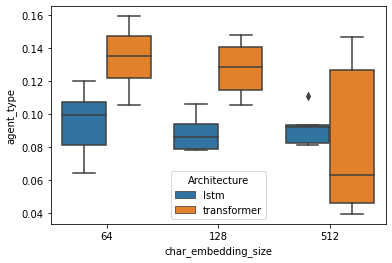

In [138]:
lstm_ttx_boxplot_comparison(sil_df, "agent_type")

In [131]:
params = [s for s in powerset(["agent_type", "starting_action", "action_pattern", "trigger", "opponent_idx"]) if len(s) > 0]

In [133]:
def plot_all_sil(df):
    past_df = df.copy()
    past_df['Architecture'] = np.where(past_df['lstm_char'] == True, "lstm", "transformer")
    img_width = 6.4
    img_height = 4.8
    fig, axes = plt.subplots(16, 2, figsize=(img_width * 2, img_height*16))

    for i, param in enumerate(params):
        param_name = ','.join(param)
        a = sns.boxplot(x=past_df["char_embedding_size"],
                        y=past_df[param_name],
                        hue=past_df["Architecture"],
                        ax=axes[i//2, i%2])
        axes[i//2, i%2].set(ylim=(0, 1))
    plt.plot()

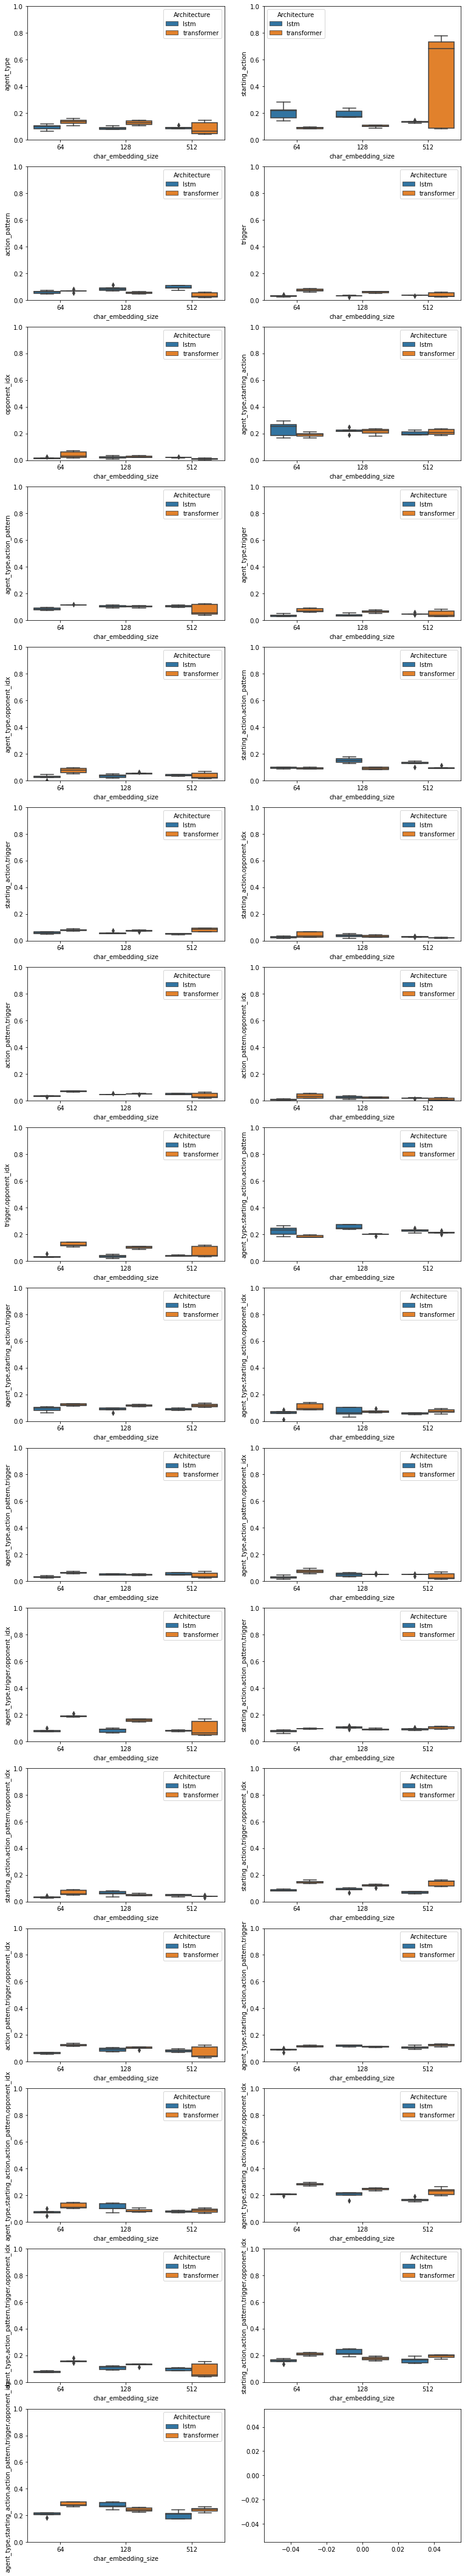

In [134]:
plot_all_sil(sil_df)

In [135]:
sil_scores = dict()
for param in params:
    param_name = ','.join(param)
    mean_sil = sil_df[param_name].mean()
    sil_scores[param_name] = mean_sil

In [136]:
print(sorted(sil_scores.items(), key = lambda kv:(kv[1], kv[0])))   

[('action_pattern,opponent_idx', 0.020598648053904375), ('opponent_idx', 0.021889832351977626), ('starting_action,opponent_idx', 0.03060312693317731), ('agent_type,opponent_idx', 0.043353221191076347), ('trigger', 0.04427593195190032), ('agent_type,action_pattern,trigger', 0.04890119687964519), ('action_pattern,trigger', 0.048916160004834335), ('agent_type,action_pattern,opponent_idx', 0.049137793791790806), ('starting_action,action_pattern,opponent_idx', 0.049276527886589365), ('agent_type,trigger', 0.05190766683469216), ('action_pattern', 0.06529702140639225), ('trigger,opponent_idx', 0.06675489383439223), ('starting_action,trigger', 0.0669736967732509), ('agent_type,starting_action,opponent_idx', 0.0730448892340064), ('action_pattern,trigger,opponent_idx', 0.08839270261426767), ('agent_type,starting_action,action_pattern,opponent_idx', 0.09115328912933668), ('starting_action,action_pattern,trigger', 0.09359062922497591), ('agent_type,action_pattern', 0.09796525004009406), ('agent_ty

In [61]:
agent_specific_df = append_modified_silhouette_scores_to_df(agent_specific_df)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1271272
0.089567944
0.093912795
0.1906643
0.11641864
0.16070169
0.17520273
0.22843665
0.087149054
0.18782787
0.17690352
0.14605623
-0.11923719
-0.12152002
-0.104835644
-0.18507664
-0.111224204
-0.1120418
0.111046515
0.22724792
0.13671461
0.17683071
0.18822792
0.14675575
0.20774132
0.21969813
0.20173481
0.23255503
0.22561333
0.25140887
-0.06236592
-0.066331856
-0.06631685
-0.08417186
-0.06198781
-0.070129886
0.27831304
0.2898642
0.28446168
0.4083594
0.3487531
0.34868965
0.40055552
0.4205617
0.2604889
0.3816068
0.42092925
0.33175838
-0.092719294
-0.097160794
-0.10041484
-0.18613108
-0.09070404
-0.08439482
0.29805937
0.37817237
0.33314142
0.4016619
0.34574968
0.37832454
0.33824733
0.39068452
0.38555568
0.41535732
0.40527594
0.4603554
-0.050160818
-0.051432252
-0.04232441
-0.07536602
-0.045715496
-0.061079353
0.40620324
0.44663465
0.3386216
0.493

0.22012793
0.31873333
0.25094253
0.32048297
0.26972264
0.39331517
0.35805038
0.33561185
0.30851185
0.3263034
0.4135535
0.36468193
-0.08912966
-0.10254467
-0.037224703
-0.091032326
-0.06251087
-0.027050663
0.31709445
0.38306722
0.3368872
0.41371566
0.25868884
0.45385578
0.38573593
0.5074903
0.40990075
0.45599002
0.39249554
0.5339105
-0.02694644
-0.069765784
-0.026157267
-0.067602016
-0.04410089
-0.053391717
0.25223443
0.36602756
0.31432372
0.3546569
0.32767758
0.426782
0.41437772
0.355297
0.3515008
0.32268035
0.4093873
0.3950341
-0.09510711
-0.10408728
-0.042091522
-0.09184735
-0.066969395
-0.02553865
0.38916424
0.4515974
0.35317978
0.43601337
0.33182675
0.49247128
0.44875008
0.56869423
0.4727714
0.53410393
0.4460102
0.59436655
-0.032009784
-0.08330025
-0.031139912
-0.060201354
-0.036939494
-0.05327278
0.29066098
0.38099903
0.32757434
0.3865886
0.34319514
0.45628974
0.43860802
0.38294706
0.39591503
0.35702926
0.4446444
0.42518604
-0.08644724
-0.10749305
-0.041108325
-0.09543589
-0.06918

0.0896003
0.061760318
0.11930851
0.07601928
0.072765015
0.073859066
0.08862238
0.10630359
0.116259076
0.10885425
0.089778386
0.08007765
-0.09339863
-0.1069944
-0.096287325
-0.106166534
-0.113634564
-0.117203064
0.08622153
0.13986175
0.13810377
0.08957596
0.06052108
0.1094682
0.07394553
0.10318925
0.11753559
0.07430273
0.14272521
0.14146554
-0.097816445
-0.10803285
-0.08455526
-0.073934354
-0.100025356
-0.07679906
0.23497617
0.16311337
0.30738842
0.22114807
0.24954471
0.17810652
0.31130257
0.22138003
0.2797016
0.25938147
0.25193113
0.18587469
-0.06816017
-0.10148008
-0.10921483
-0.09613202
-0.092563674
-0.09141247
0.18460526
0.20866966
0.20217691
0.17377788
0.1486457
0.20674534
0.109257944
0.2302058
0.17913888
0.1544537
0.21167572
0.21586093
-0.08564843
-0.102374576
-0.095064685
-0.07942514
-0.119538516
-0.09149616


KeyboardInterrupt: 

In [62]:
agent_specific_df[agent_specific_df["n_past"] == 5].groupby("model_name")[["model_name", "new_modified_cluster_silhouette_score"]].aggregate("mean")

,new_modified_cluster_silhouette_score
model_name,
"lstm[128,1]_lstm[64,1]_seed1",0.136646
"lstm[128,1]_lstm[64,1]_seed2",0.145302
"lstm[128,1]_lstm[64,1]_seed3",0.135648
"lstm[128,1]_lstm[64,1]_seed4",0.117138
"lstm[128,1]_lstm[64,1]_seed5",0.129664
"lstm[512,1]_lstm[64,1]_seed1",0.120811
"lstm[512,1]_lstm[64,1]_seed2",0.105307
"lstm[512,1]_lstm[64,1]_seed3",0.113674
"lstm[512,1]_lstm[64,1]_seed4",0.142232


In [120]:
param_score_df 

,model_name,n_past,agent_type,starting_action_score,starting_action_dim,trigger_score,trigger_dim,action_pattern_score,action_pattern_dim,opponent_idx_score,opponent_idx_dim
0,"lstm[128,1]_lstm[64,1]_seed1",5,mirror,0.239793,-1,NaN,-1,NaN,-1,0.471638,-1
1,"lstm[128,1]_lstm[64,1]_seed1",5,grim_trigger,0.514718,-1,0.075712,-1,NaN,-1,0.076061,-1
2,"lstm[128,1]_lstm[64,1]_seed1",5,wsls,0.717958,-1,-0.000952,-1,NaN,-1,-0.003734,-1
3,"lstm[128,1]_lstm[64,1]_seed1",5,mixed_trigger_pattern,0.260291,-1,0.056422,-1,0.077232,-1,0.048290,-1
4,"lstm[128,1]_lstm[64,1]_seed2",5,mirror,0.291304,-1,NaN,-1,NaN,-1,0.434912,-1
...,...,...,...,...,...,...,...,...,...,...,...
115,"ttx[64,4,4]_ttx[64,4,4]_seed4",5,mixed_trigger_pattern,0.121955,-1,0.106289,-1,0.058521,-1,0.028192,-1
116,"ttx[64,4,4]_ttx[64,4,4]_seed5",5,mirror,0.197117,-1,NaN,-1,NaN,-1,0.545193,-1
117,"ttx[64,4,4]_ttx[64,4,4]_seed5",5,grim_trigger,0.298206,-1,0.138503,-1,NaN,-1,0.135530,-1
118,"ttx[64,4,4]_ttx[64,4,4]_seed5",5,wsls,0.579092,-1,-0.000772,-1,NaN,-1,-0.004160,-1


In [121]:
from tommas.analysis.representation_metrics import get_param_silhouette_and_dim

In [122]:
def append_agent_specific_param_scores(df, mask_threshold=.75):
    # Looking at how well we can tell an agent's parameter values from each other as well as from non-existent values, i.e. grim trigger's start action = 0 vs 1 (as well as vs non grim trigger agents)
    def get_agent_param_scores():
        data = []
        for agent_type in agent_types:
            param_scores = {"model_name": model_name, "n_past": n_past, "agent_type": agent_type}
            for agent_param in agent_params:
                criteria = (agent_df["agent_type"] == agent_type)
                embedding_df = agent_df[criteria][[agent_param, "char_embedding"]]
                if len(embedding_df[agent_param].unique()) > 1:
                    labels = []
                    embeddings = []
                    for i, group_embeddings in enumerate(
                            embedding_df.groupby(agent_param)["char_embedding"].apply(lambda a: np.vstack(a))):
                        labels = labels + [i for _ in range(group_embeddings.shape[0])]
                        embeddings.append(group_embeddings)
                    param_embeddings = np.concatenate(embeddings, axis=0)
                    param_labels = np.array(labels)
                    silhouette, feature_dim = get_param_silhouette_and_dim(param_embeddings, param_labels, mask_threshold)
                else:
                    silhouette = np.nan
                    feature_dim = np.nan
                param_scores.update({f"{agent_param}_score": silhouette, f"{agent_param}_dim": feature_dim})
            data.append(param_scores)
        return data

    agent_params = ['starting_action', 'trigger', 'action_pattern', 'opponent_idx']
    agent_types = df["agent_type"].unique()
    dfs = dict(tuple(df[df["n_past"].isin([5])][["model_name", 'agent_type', *agent_params, "n_past", "char_embedding"]].groupby(["model_name", "n_past"])))
    agent_param_data = []
    for (model_name, n_past), agent_df in tqdm(dfs.items()):
        agent_param_data.extend(get_agent_param_scores())

#     return df.merge(pd.DataFrame(agent_param_data), how="left", on=["model_name", "n_past", "agent_type"])
    return pd.DataFrame(agent_param_data)

In [125]:
param_score_df = append_agent_specific_param_scores(agent_specific_df)

100%|██████████| 30/30 [02:48<00:00,  5.63s/it]


In [126]:
param_score_df 

,model_name,n_past,agent_type,starting_action_score,starting_action_dim,trigger_score,trigger_dim,action_pattern_score,action_pattern_dim,opponent_idx_score,opponent_idx_dim
0,"lstm[128,1]_lstm[64,1]_seed1",5,mirror,0.926855,1,NaN,NaN,NaN,NaN,0.687191,20
1,"lstm[128,1]_lstm[64,1]_seed1",5,grim_trigger,0.768222,10,0.138214,7.0,NaN,NaN,0.076150,72
2,"lstm[128,1]_lstm[64,1]_seed1",5,wsls,0.821900,16,-1.000000,0.0,NaN,NaN,-0.003707,82
3,"lstm[128,1]_lstm[64,1]_seed1",5,mixed_trigger_pattern,0.795952,3,0.154276,8.0,0.077527,67.0,0.048369,70
4,"lstm[128,1]_lstm[64,1]_seed2",5,mirror,0.847863,3,NaN,NaN,NaN,NaN,0.450476,30
...,...,...,...,...,...,...,...,...,...,...,...
115,"ttx[64,4,4]_ttx[64,4,4]_seed4",5,mixed_trigger_pattern,0.270548,15,0.287913,13.0,0.058521,64.0,0.028192,64
116,"ttx[64,4,4]_ttx[64,4,4]_seed5",5,mirror,0.411524,16,NaN,NaN,NaN,NaN,0.584381,57
117,"ttx[64,4,4]_ttx[64,4,4]_seed5",5,grim_trigger,0.536576,19,0.280814,20.0,NaN,NaN,0.135530,64
118,"ttx[64,4,4]_ttx[64,4,4]_seed5",5,wsls,0.680111,30,-1.000000,0.0,NaN,NaN,-0.004160,64


In [154]:
agent_specific_df[["model_name", "agent_label", "cluster_silhouette_score"]]

,model_name,agent_label,cluster_silhouette_score
0,"lstm[128,1]_lstm[64,1]_seed1","mirror, starting_action:0, opponent_idx:1",0.000000
1,"lstm[128,1]_lstm[64,1]_seed1","mirror, starting_action:0, opponent_idx:1",0.282927
2,"lstm[128,1]_lstm[64,1]_seed1","mirror, starting_action:0, opponent_idx:1",0.362288
3,"lstm[128,1]_lstm[64,1]_seed1","mirror, starting_action:0, opponent_idx:1",0.407047
4,"lstm[128,1]_lstm[64,1]_seed1","mirror, starting_action:0, opponent_idx:1",0.439331
...,...,...,...
11875,"ttx[64,4,4]_ttx[64,4,4]_seed5","mixed_trigger_pattern, mixed_strategy:01.0, tr...",-0.085626
11876,"ttx[64,4,4]_ttx[64,4,4]_seed5","mixed_trigger_pattern, mixed_strategy:01.0, tr...",-0.091486
11877,"ttx[64,4,4]_ttx[64,4,4]_seed5","mixed_trigger_pattern, mixed_strategy:01.0, tr...",-0.094553
11878,"ttx[64,4,4]_ttx[64,4,4]_seed5","mixed_trigger_pattern, mixed_strategy:01.0, tr...",-0.086665


In [ ]:
def aggregate_model_specific_data(agent_specific_df):
    model_params = ["model_name", "model_seed", "model_family", 'lstm_char', 'lstm_mental', 'char_embedding_size',
                    'char_n_layer', 'char_n_head', 'mental_embedding_size', 'mental_n_layer', 'mental_n_head']

    model_specific_df = agent_specific_df[[*model_params, "n_past", "loss", "acc", "cluster_silhouette_score",
                                           "modified_cluster_silhouette_score", *agent_specific_param_metrics]]
    model_specific_df = model_specific_df.groupby([*model_params, "n_past"]).agg(['describe']).reset_index()
    model_specific_df.columns = model_specific_df.columns.droplevel(1)
    return model_specific_df

In [142]:
p_df = param_score_df[["model_name", "starting_action_score", "starting_action_dim", "trigger_score", "action_pattern_score", "opponent_idx_score"]]
p_df = p_df.fillna(0)
# p_df[p_df.isna() == True]
p_df = p_df.groupby(["model_name"]).agg(['mean']).reset_index()
# p_df
p_df.columns = p_df.columns.droplevel(1)
p_df

,model_name,starting_action_score,starting_action_dim,trigger_score,action_pattern_score,opponent_idx_score
0,"lstm[128,1]_lstm[64,1]_seed1",0.828232,7.50,-0.176877,0.019382,0.202001
1,"lstm[128,1]_lstm[64,1]_seed2",0.803367,9.00,-0.113380,0.012883,0.133598
2,"lstm[128,1]_lstm[64,1]_seed3",0.840904,6.00,-0.131680,0.015161,0.164027
3,"lstm[128,1]_lstm[64,1]_seed4",0.828244,8.25,-0.132553,0.009686,0.199916
4,"lstm[128,1]_lstm[64,1]_seed5",0.784207,8.75,-0.144572,0.015358,0.229429
5,"lstm[512,1]_lstm[64,1]_seed1",0.756486,12.50,0.133864,0.020478,0.205426
6,"lstm[512,1]_lstm[64,1]_seed2",0.793256,12.00,-0.164721,0.017558,0.192504
7,"lstm[512,1]_lstm[64,1]_seed3",0.755589,11.50,-0.159025,0.013602,0.172873
8,"lstm[512,1]_lstm[64,1]_seed4",0.771002,16.25,-0.139609,0.015265,0.185918
9,"lstm[512,1]_lstm[64,1]_seed5",0.732408,12.00,-0.150782,0.019761,0.225666


In [150]:
new_param_score_df = append_agent_specific_param_scores(agent_specific_df)

100%|██████████| 30/30 [02:49<00:00,  5.66s/it]


In [152]:
p_df = new_param_score_df[["model_name", "starting_action_score", "starting_action_dim", "trigger_score", "action_pattern_score", "opponent_idx_score"]]
p_df = p_df.fillna(0)
# p_df[p_df.isna() == True]
p_df = p_df.groupby(["model_name"]).agg(['mean']).reset_index()
# p_df
p_df.columns = p_df.columns.droplevel(1)
p_df

,model_name,starting_action_score,starting_action_dim,trigger_score,action_pattern_score,opponent_idx_score
0,"lstm[128,1]_lstm[64,1]_seed1",0.839710,6.00,-0.173771,0.045546,0.228371
1,"lstm[128,1]_lstm[64,1]_seed2",0.812502,6.75,-0.113380,0.036587,0.205777
2,"lstm[128,1]_lstm[64,1]_seed3",0.850978,5.00,-0.130000,0.027922,0.174900
3,"lstm[128,1]_lstm[64,1]_seed4",0.841555,6.25,-0.131055,0.040129,0.217674
4,"lstm[128,1]_lstm[64,1]_seed5",0.807282,6.75,-0.146185,0.042023,0.258538
5,"lstm[512,1]_lstm[64,1]_seed1",0.843073,7.25,-0.117709,0.055613,0.236295
6,"lstm[512,1]_lstm[64,1]_seed2",0.871386,6.75,-0.161115,0.071757,0.209586
7,"lstm[512,1]_lstm[64,1]_seed3",0.802864,7.50,-0.155863,0.046466,0.248153
8,"lstm[512,1]_lstm[64,1]_seed4",0.870132,7.75,-0.135118,0.055603,0.231917
9,"lstm[512,1]_lstm[64,1]_seed5",0.793514,7.50,-0.156586,0.047812,0.233022


# looking at embedding distribution

In [47]:
def plot_embedding_space_as_boxplot(df, model_name="lstm[64,1]_lstm[64,2]_seed1", percentile_order=-1):
    embeddings = np.vstack(df[(df["model_name"]==model_name) & (df["n_past"] == 5)].char_embedding.tolist())
    if percentile_order == -1:
        if "ttx" in model_name:
            percentile_order = 2
        else: 
            percentile_order = 0
    percentiles = np.percentile(embeddings, [0, 25, 50, 75, 100], axis=0)
    embeddings = embeddings[:, np.argsort(percentiles[percentile_order, :])]
    fig, ax = plt.subplots(figsize=(18, 6))
    g1 = sns.boxplot(data=embeddings, ax=ax)
    g1.set(xticks=[], ylim=(-1.5, 1.5))

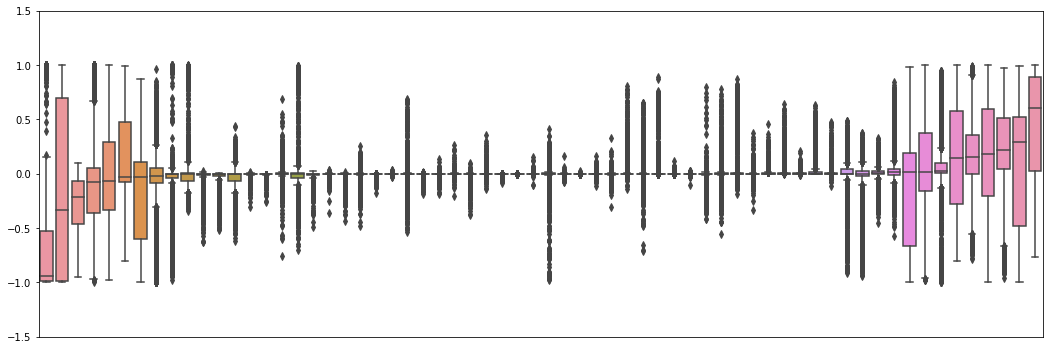

In [48]:
plot_embedding_space_as_boxplot(agent_specific_df, 'lstm[64,1]_lstm[64,1]_seed1', percentile_order=2)

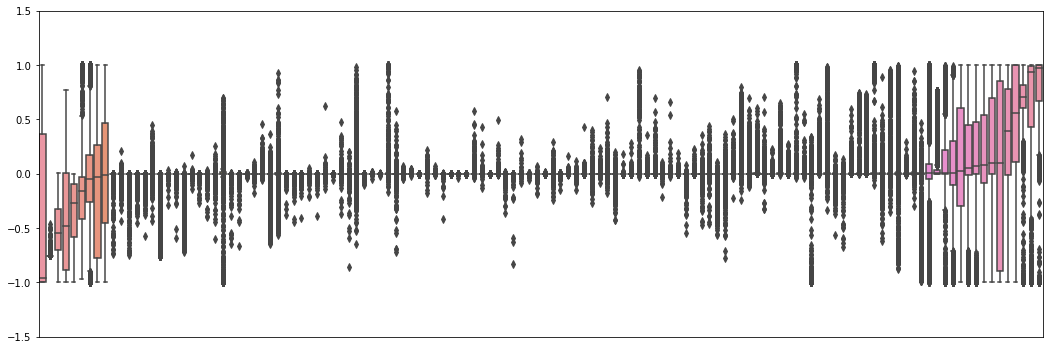

In [49]:
plot_embedding_space_as_boxplot(agent_specific_df, 'lstm[128,1]_lstm[64,1]_seed1', percentile_order=2)

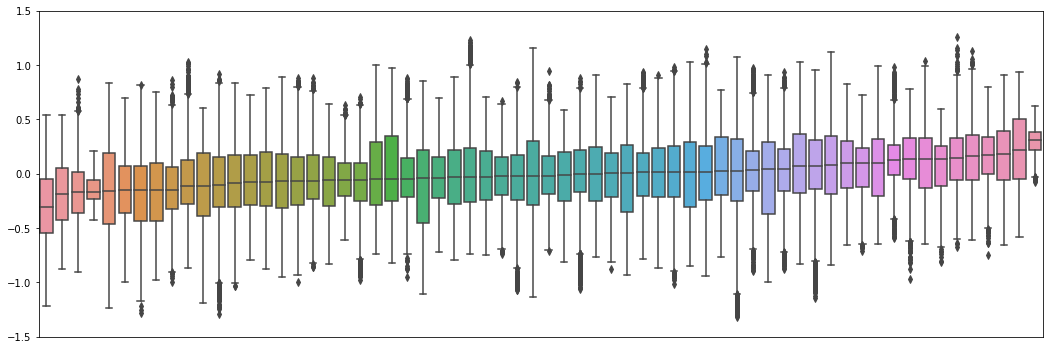

In [51]:
plot_embedding_space_as_boxplot(agent_specific_df, 'ttx[64,4,4]_ttx[64,4,4]_seed1', percentile_order=2)

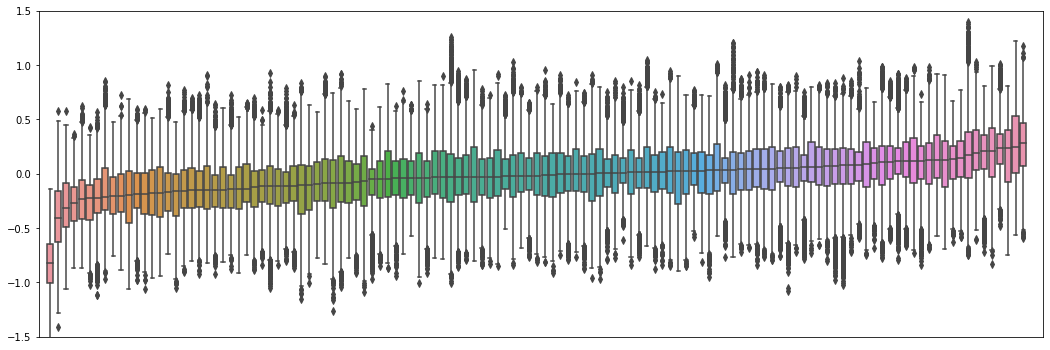

In [52]:
plot_embedding_space_as_boxplot(agent_specific_df, 'ttx[128,4,4]_ttx[64,4,4]_seed1', percentile_order=2)

In [9]:
def append_distributional_variance(agent_specific_df, model_specific_df):
    data = []
    models_names = agent_specific_df["model_name"].unique()
    for model_name in models_names:
        embedding_df = agent_specific_df[agent_specific_df["model_name"] == model_name][["n_past", "char_embedding"]]
        x = embedding_df.groupby(["n_past"])["char_embedding"].apply(lambda a: np.vstack(a))
        n_past = len(x)
        for n_p in range(n_past):
            embeddings = x[n_p]
            overall_var = np.mean(np.var(embeddings, axis=0))
            cov_mean = np.mean(np.cov(embeddings.T))
            
            data.append({"model_name": model_name, "n_past": n_p, "overall_var": overall_var,
                         "cov_mean": cov_mean})
    df = pd.DataFrame(data)
    df.columns = pd.MultiIndex.from_tuples([(col, "") for col in df.columns], names=[None, None])
    return model_specific_df.merge(df, how="left", on=["model_name", "n_past"])


In [10]:
model_specific_df = append_distributional_variance(agent_specific_df, model_specific_df)

/home/kane0058/Documents/TOMMAS/venv/lib/python3.6/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [11]:
# var_corr_comp = ["char_embedding_size", "shared_starting_action_score", 
#                  "agent_type_score", "final_embedding_similarity", 
#                  "completeness", "disentanglement", "informativeness", 
#                  "top_20_var", "overall_var", "cov_mean", "cov_sum"]
# var_corr_comp = ["char_embedding_size", "shared_starting_action_score", 
#                  "agent_type_score", "final_embedding_similarity", 
#                  "completeness", "disentanglement", "informativeness",
#                  ("loss", "mean"), ("acc", "mean"), "pca_50%", #"modified_clustering_silhouette_score",
#                  "overall_var", "cov_mean"]

var_corr_comp = ["char_embedding_size", "shared_starting_action_score", 
                 "agent_type_score",
                 "completeness", "disentanglement", "informativeness",
                 "loss" , "acc", "pca_50%", #"modified_clustering_silhouette_score",
                 "overall_var", "cov_mean"]

In [12]:
model_specific_df[model_specific_df["n_past"] == 5].corr()[["overall_var", "cov_mean"]].loc[var_corr_comp]

overall_var  cov_mean
                                                        
char_embedding_size                  -0.400151 -0.473968
shared_starting_action_score         -0.377293  0.408883
agent_type_score                     -0.215427 -0.343662
completeness                         -0.539462  0.283471
disentanglement                      -0.162829  0.158317
informativeness                      -0.084901 -0.194987
loss                         count         NaN       NaN
                             mean     0.206908 -0.243495
                             std      0.209742 -0.262593
                             min     -0.505323  0.590067
                             25%     -0.515423  0.517335
                             50%     -0.522785  0.506468
                             75%     -0.589829  0.413468
                             max      0.201946 -0.274498
acc                          count         NaN       NaN
                             mean    -0.099831 -0.084053
                             std      0.034549  0.084553
                             min      0.039280 -0.104937
                             25%      0.451509 -0.474886
                             50%      0.468652 -0.552350
                             75%      0.237123 -0.580920
                             max           NaN       NaN
pca_50%                              -0.559551 -0.170595
overall_var                           1.000000 -0.149339
cov_mean                             -0.149339  1.000000

In [13]:
model_specific_df[(model_specific_df["n_past"] == 5) & 
                  (model_specific_df["lstm_char"] == True)].corr()[["overall_var", "cov_mean"]].loc[var_corr_comp]

overall_var  cov_mean
                                                        
char_embedding_size                  -0.827839 -0.855744
shared_starting_action_score         -0.255605 -0.535556
agent_type_score                     -0.417552 -0.482285
completeness                         -0.781010 -0.936754
disentanglement                       0.091105  0.034468
informativeness                      -0.332986 -0.198096
loss                         count         NaN       NaN
                             mean     0.263715  0.156742
                             std      0.179637  0.085359
                             min     -0.103162  0.072763
                             25%     -0.143462 -0.208292
                             50%     -0.228082 -0.189426
                             75%     -0.384411 -0.270300
                             max      0.093306  0.007923
acc                          count         NaN       NaN
                             mean    -0.265917 -0.131246
                             std      0.171461  0.046327
                             min     -0.108778  0.022675
                             25%      0.122796  0.008197
                             50%     -0.004113 -0.041729
                             75%     -0.300116 -0.342699
                             max           NaN       NaN
pca_50%                              -0.832951 -0.854523
overall_var                           1.000000  0.816851
cov_mean                              0.816851  1.000000

In [14]:
model_specific_df[(model_specific_df["n_past"] == 5) & 
                  (model_specific_df["lstm_char"] == False)].corr()[["overall_var", "cov_mean"]].loc[var_corr_comp]

overall_var      cov_mean
                                                              
char_embedding_size                -3.803454e-01 -6.138365e-01
shared_starting_action_score        1.610869e-01 -3.483682e-01
agent_type_score                   -3.232921e-01  7.326589e-02
completeness                       -1.326634e-02 -2.225859e-01
disentanglement                    -1.741469e-01 -1.904437e-01
informativeness                    -1.414465e-01 -4.353138e-02
loss                         count           NaN           NaN
                             mean  -8.308816e-02 -5.548360e-01
                             std   -8.353715e-02 -5.399798e-01
                             min    5.300513e-01  7.835372e-01
                             25%    4.021396e-01  8.179050e-01
                             50%    6.564299e-01  6.987382e-01
                             75%   -3.392096e-01 -5.862586e-01
                             max   -6.864971e-02 -5.096068e-01
acc                          count           NaN           NaN
                             mean  -5.733091e-02  3.123256e-01
                             std    1.121295e-01 -1.874714e-01
                             min   -1.802394e-01 -1.156195e-01
                             25%    1.923129e-02  9.576434e-02
                             50%    1.769847e-16  1.378003e-16
                             75%             NaN           NaN
                             max             NaN           NaN
pca_50%                            -1.839661e-01 -5.472302e-01
overall_var                         1.000000e+00  5.989941e-01
cov_mean                            5.989941e-01  1.000000e+00

In [60]:
def hist_all_embeddings(df, model_name, norm_x=False):
    binrange=(-1.5, 1.5)
    char_embed_size = df[(df["model_name"]==model_name)].char_embedding_size.unique()[0]
    cols = 8
    rows = char_embed_size // cols
    embeddings = np.vstack(df[(df["model_name"]==model_name) & (df["n_past"]==5)].char_embedding.tolist())
    embeddings = embeddings[:, np.argsort(np.var(embeddings, axis=0))]
    col_size = 15
    row_size = int(col_size * (rows / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(col_size, row_size))
    for i in range(rows):
        for j in range(cols):
#             g = sns.kdeplot(embeddings[:, 8*i+j], ax=axes[i,j])
#             bincount, bins = np.histogram(embeddings[:, (cols*i)+j], bins=100, range=(-1.5, 1.5))
#             print(np.sort(bincount)[-4:])
            embedding1d = embeddings[:, (cols*i)+j]
            g = sns.histplot(embeddings[:, (cols*i)+j], ax=axes[i,j], bins=100, stat="percent", binrange=binrange)
            if norm_x:
                g.set(xlim=(np.min(embedding1d), np.max(embedding1d)), ylim=(0, 20), ylabel='')
            else:
                g.set(xlim=binrange, ylim=(0, 20), ylabel='')
    plt.plot()

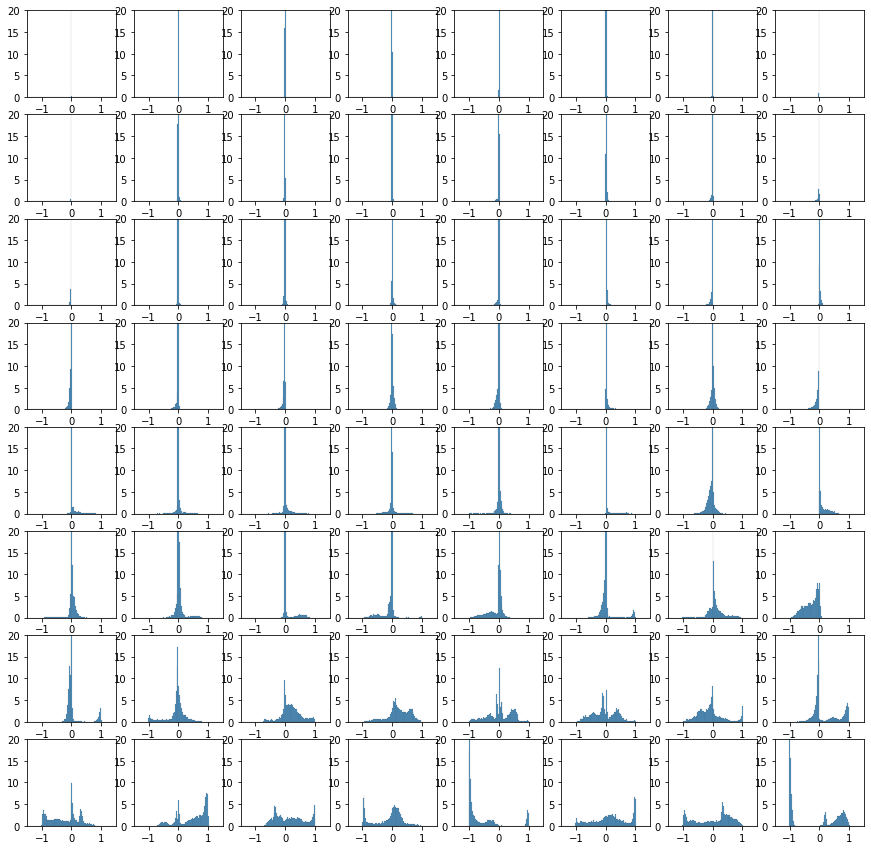

In [61]:
hist_all_embeddings(agent_specific_df, "lstm[64,1]_lstm[64,1]_seed1", norm_x=False)

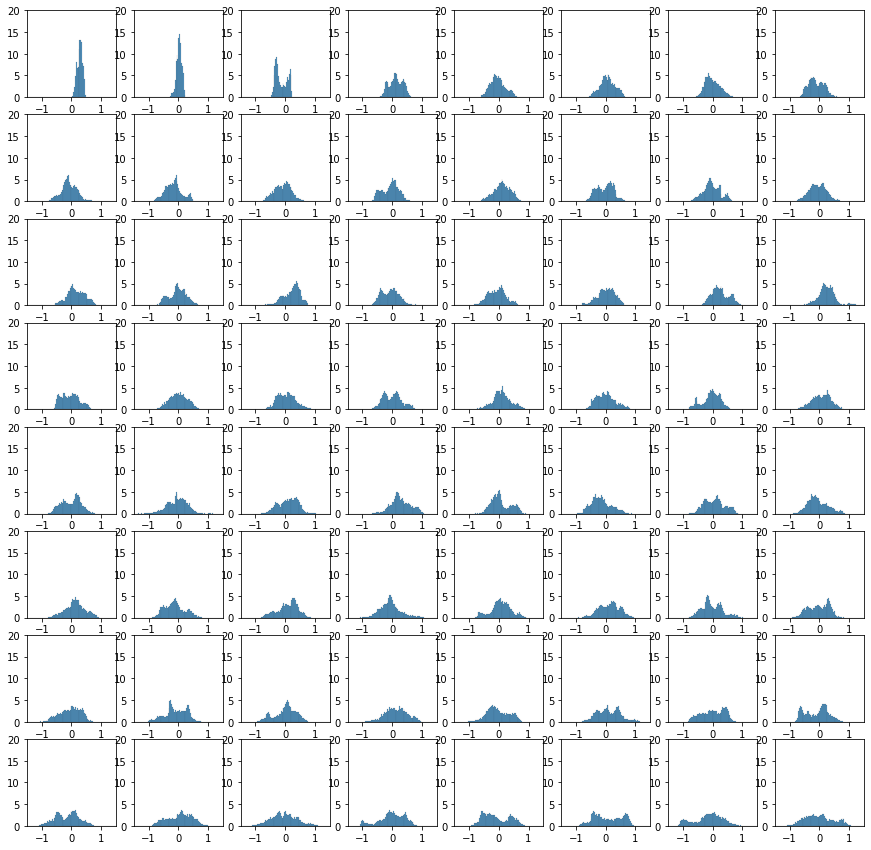

In [62]:
hist_all_embeddings(agent_specific_df, "ttx[64,4,4]_ttx[64,4,4]_seed4", norm_x=False)